In [1]:
import sys
import os 

sys.path.append('/home/klamdibih/Deep-Chemometrics')

import src
from itertools import product
import pandas as pd

In [2]:

import scipy as sp
import random
from torch import nn
from torch import optim
import torch.utils.data as data_utils
from sklearn.model_selection import train_test_split
import numpy as np
from src.utils import TrainerConfig
from src.training.training import Trainer
import seaborn as sns
import torch
import matplotlib.pyplot as plt
import copy
from sklearn.metrics import r2_score
from src.net import Darionet
from src.net.SWAG import SWAG

def set_seed(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False


set_seed(42)


2025-06-13 09:52:17.246148: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1749801137.431321    6186 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1749801137.482250    6186 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1749801137.810485    6186 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1749801137.810543    6186 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1749801137.810550    6186 computation_placer.cc:177] computation placer alr

In [3]:
# Device setup
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

data = sp.io.loadmat("../data/dataset/Mango/mango_dm_full_outlier_removed2.mat")
print(data.keys())

Ycal = data["DM_cal"]
Ytest = data["DM_test"]
Xcal = data["SP_all_train"]
Xtest = data["SP_all_test"]


dict_keys(['__header__', '__version__', '__globals__', 'DM_cal', 'DM_test', 'Sp_cal', 'Sp_test', 'wave', 'SP_all_test', 'SP_all_train'])


In [4]:
## Spliting the train set
x_cal, x_val, y_cal, y_val = train_test_split(Xcal, Ycal, test_size=0.20, shuffle=True, random_state=42)

# calculate mean and std per column

mean = np.mean(x_cal, axis=0)
std = np.std(x_cal, axis=0)

cal = data_utils.TensorDataset(torch.Tensor(x_cal), torch.Tensor(y_cal))
val = data_utils.TensorDataset(torch.Tensor(x_val), torch.Tensor(y_val))
test_dt = data_utils.TensorDataset(torch.Tensor(Xtest), torch.Tensor(Ytest))

In [5]:
# Model parameters
model_name = "Darionet_Mango_uncertainty"
p = 0.02
filter_size = 5
reg_beta = 0.01
num_epochs = 500

# Training configuration
config = TrainerConfig(model_name=model_name)
config.update_config(batch_size=128, num_epochs=num_epochs, save_model=True,
                     classification=False, max_loss_plot=20)

# Data loading
data_path = "data/dataset/Mango/mango_dm_full_outlier_removed2.mat"
save_path = os.path.dirname(os.path.abspath(data_path)) + f'/models/{model_name}/' + model_name
print("Save path:", save_path)

cal_loader = data_utils.DataLoader(cal, batch_size=config.batch_size, shuffle=True)
val_loader = data_utils.DataLoader(val, batch_size=config.batch_size, shuffle=False)
test_loader = data_utils.DataLoader(test_dt, batch_size=config.batch_size, shuffle=False)



Save path: /home/klamdibih/Deep-Chemometrics/notebook/data/dataset/Mango/models/Darionet_Mango_uncertainty/Darionet_Mango_uncertainty


# MC DROPOUT

In [9]:
os.makedirs("result_csv", exist_ok=True)

Training: filter_size=3, learning_rate=0.0001, dropout=0.02
Saving best model to /home/klamdibih/Deep-Chemometrics/models/Darionet_Mango_uncertainty_best.pth
Epoch 1/500 | Train Loss: 86.2759 | Val Loss: 26.6915 | Val Mean Metrics: -0.3877
Model saved at epoch 0 to /home/klamdibih/Deep-Chemometrics/models/Darionet_Mango_uncertainty_best.pth
Epoch 2/500 | Train Loss: 17.4525 | Val Loss: 10.7384 | Val Mean Metrics: -0.0143
Model saved at epoch 1 to /home/klamdibih/Deep-Chemometrics/models/Darionet_Mango_uncertainty_best.pth
Epoch 3/500 | Train Loss: 9.6541 | Val Loss: 6.5365 | Val Mean Metrics: 0.1914
Model saved at epoch 2 to /home/klamdibih/Deep-Chemometrics/models/Darionet_Mango_uncertainty_best.pth
Model saved at epoch 2 to /home/klamdibih/Deep-Chemometrics/models/Darionet_Mango_uncertainty_best.pth
Epoch 4/500 | Train Loss: 6.8047 | Val Loss: 4.4927 | Val Mean Metrics: 0.3621
Model saved at epoch 3 to /home/klamdibih/Deep-Chemometrics/models/Darionet_Mango_uncertainty_best.pth
Epoch

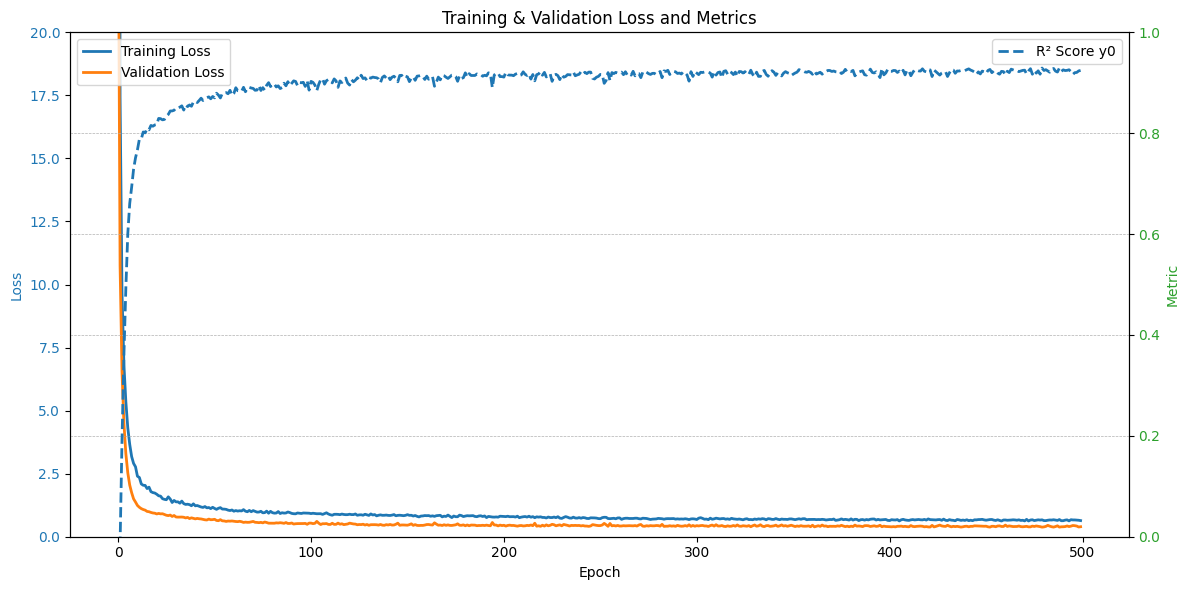

/tmp/ipykernel_4089/2701852342.py:29: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(final_path, map_location=config.device))


Training: filter_size=3, learning_rate=0.0001, dropout=0.01
Saving best model to /home/klamdibih/Deep-Chemometrics/models/Darionet_Mango_uncertainty_best.pth
Epoch 1/500 | Train Loss: 160.3855 | Val Loss: 80.9542 | Val Mean Metrics: -7.8571
Model saved at epoch 0 to /home/klamdibih/Deep-Chemometrics/models/Darionet_Mango_uncertainty_best.pth
Epoch 2/500 | Train Loss: 45.7125 | Val Loss: 23.5283 | Val Mean Metrics: -0.5102
Model saved at epoch 1 to /home/klamdibih/Deep-Chemometrics/models/Darionet_Mango_uncertainty_best.pth
Epoch 3/500 | Train Loss: 17.4740 | Val Loss: 12.1048 | Val Mean Metrics: -0.0467
Model saved at epoch 2 to /home/klamdibih/Deep-Chemometrics/models/Darionet_Mango_uncertainty_best.pth
Epoch 4/500 | Train Loss: 10.7668 | Val Loss: 8.0471 | Val Mean Metrics: 0.1594
Model saved at epoch 3 to /home/klamdibih/Deep-Chemometrics/models/Darionet_Mango_uncertainty_best.pth
Model saved at epoch 3 to /home/klamdibih/Deep-Chemometrics/models/Darionet_Mango_uncertainty_best.pth


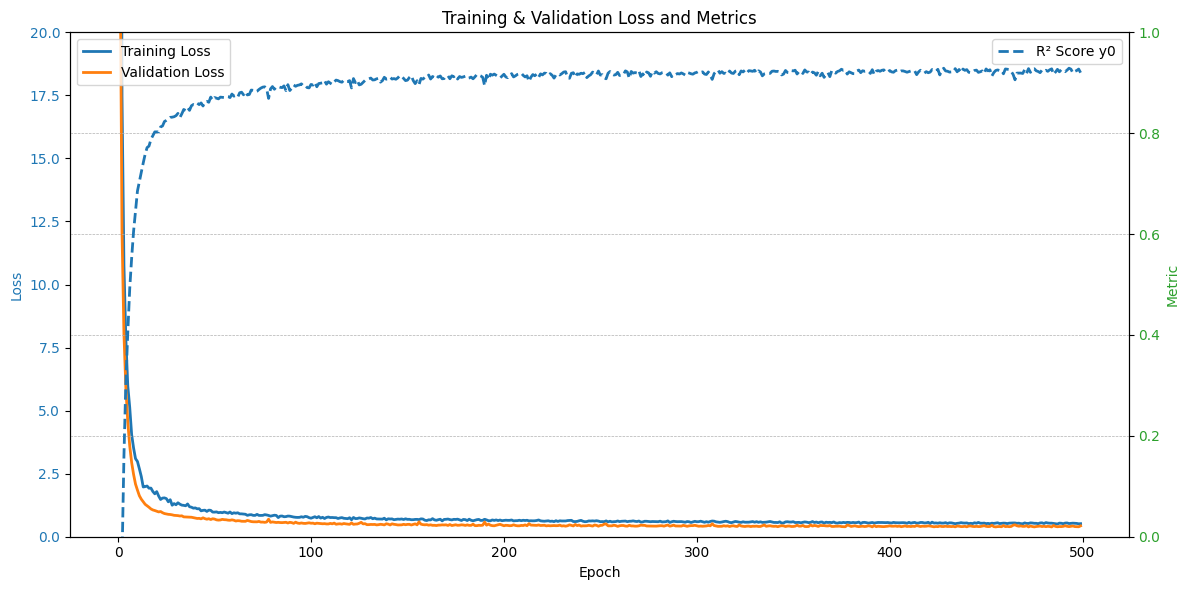

Training: filter_size=3, learning_rate=0.0001, dropout=0.1
Saving best model to /home/klamdibih/Deep-Chemometrics/models/Darionet_Mango_uncertainty_best.pth
Epoch 1/500 | Train Loss: 93.6221 | Val Loss: 29.5987 | Val Mean Metrics: -0.3486
Model saved at epoch 0 to /home/klamdibih/Deep-Chemometrics/models/Darionet_Mango_uncertainty_best.pth
Epoch 2/500 | Train Loss: 22.5471 | Val Loss: 11.5754 | Val Mean Metrics: 0.0372
Model saved at epoch 1 to /home/klamdibih/Deep-Chemometrics/models/Darionet_Mango_uncertainty_best.pth
Model saved at epoch 1 to /home/klamdibih/Deep-Chemometrics/models/Darionet_Mango_uncertainty_best.pth
Epoch 3/500 | Train Loss: 13.5708 | Val Loss: 6.8783 | Val Mean Metrics: 0.2613
Model saved at epoch 2 to /home/klamdibih/Deep-Chemometrics/models/Darionet_Mango_uncertainty_best.pth
Epoch 4/500 | Train Loss: 9.7259 | Val Loss: 4.8841 | Val Mean Metrics: 0.3674
Model saved at epoch 3 to /home/klamdibih/Deep-Chemometrics/models/Darionet_Mango_uncertainty_best.pth
Epoch 

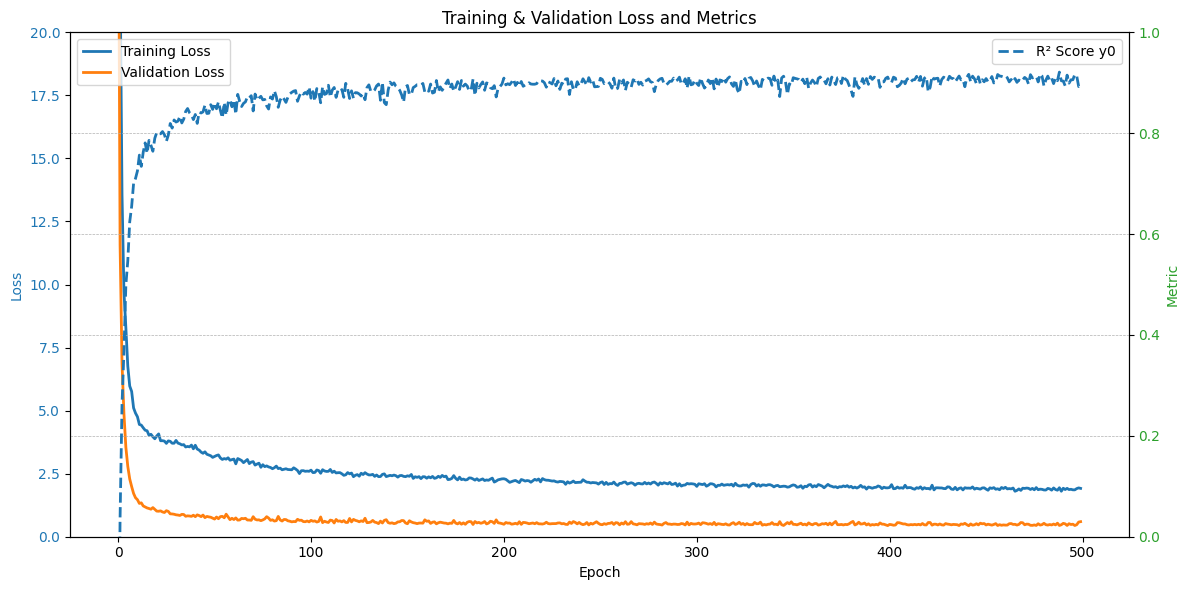

Training: filter_size=3, learning_rate=0.0001, dropout=0.2
Saving best model to /home/klamdibih/Deep-Chemometrics/models/Darionet_Mango_uncertainty_best.pth
Epoch 1/500 | Train Loss: 218.9733 | Val Loss: 166.6326 | Val Mean Metrics: -43.1141
Model saved at epoch 0 to /home/klamdibih/Deep-Chemometrics/models/Darionet_Mango_uncertainty_best.pth
Epoch 2/500 | Train Loss: 113.0132 | Val Loss: 64.8381 | Val Mean Metrics: -2.3645
Model saved at epoch 1 to /home/klamdibih/Deep-Chemometrics/models/Darionet_Mango_uncertainty_best.pth
Epoch 3/500 | Train Loss: 54.6170 | Val Loss: 32.1785 | Val Mean Metrics: -0.9559
Model saved at epoch 2 to /home/klamdibih/Deep-Chemometrics/models/Darionet_Mango_uncertainty_best.pth
Epoch 4/500 | Train Loss: 33.4733 | Val Loss: 15.6026 | Val Mean Metrics: -0.7571
Model saved at epoch 3 to /home/klamdibih/Deep-Chemometrics/models/Darionet_Mango_uncertainty_best.pth
Epoch 5/500 | Train Loss: 20.4465 | Val Loss: 6.9276 | Val Mean Metrics: -0.3687
Model saved at epo

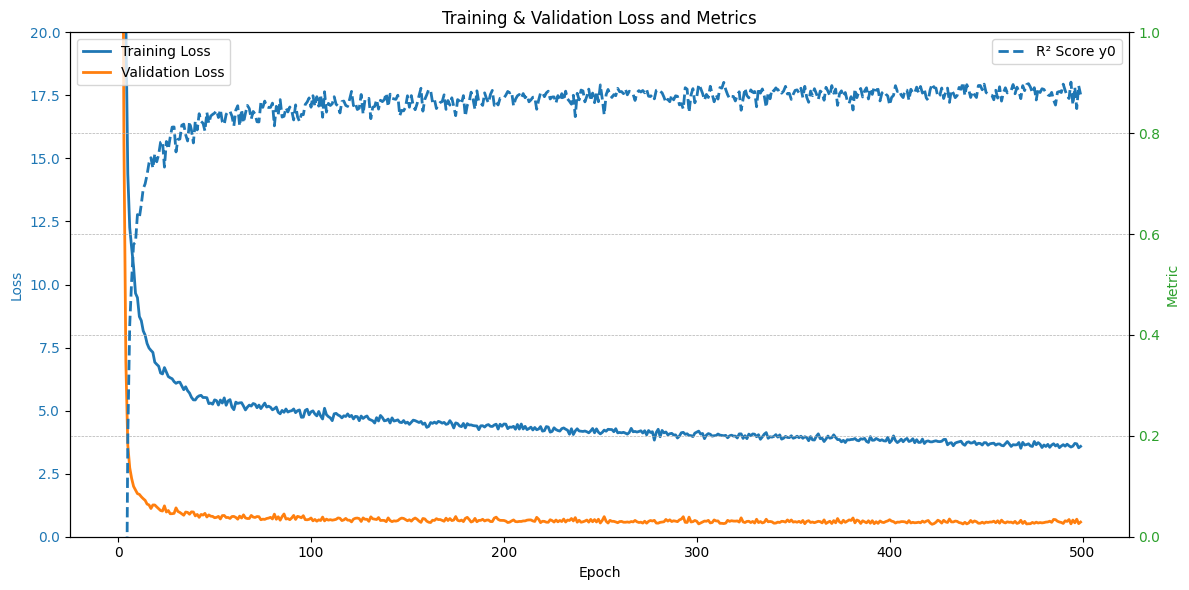

Training: filter_size=3, learning_rate=0.001, dropout=0.02
Saving best model to /home/klamdibih/Deep-Chemometrics/models/Darionet_Mango_uncertainty_best.pth
Epoch 1/500 | Train Loss: 32.7418 | Val Loss: 2.9050 | Val Mean Metrics: 0.5520
Model saved at epoch 0 to /home/klamdibih/Deep-Chemometrics/models/Darionet_Mango_uncertainty_best.pth
Model saved at epoch 0 to /home/klamdibih/Deep-Chemometrics/models/Darionet_Mango_uncertainty_best.pth
Epoch 2/500 | Train Loss: 3.2270 | Val Loss: 1.4558 | Val Mean Metrics: 0.7075
Model saved at epoch 1 to /home/klamdibih/Deep-Chemometrics/models/Darionet_Mango_uncertainty_best.pth
Epoch 3/500 | Train Loss: 2.3779 | Val Loss: 1.1726 | Val Mean Metrics: 0.7700
Model saved at epoch 2 to /home/klamdibih/Deep-Chemometrics/models/Darionet_Mango_uncertainty_best.pth
Epoch 4/500 | Train Loss: 1.9884 | Val Loss: 0.9541 | Val Mean Metrics: 0.8074
Model saved at epoch 3 to /home/klamdibih/Deep-Chemometrics/models/Darionet_Mango_uncertainty_best.pth
Epoch 5/500

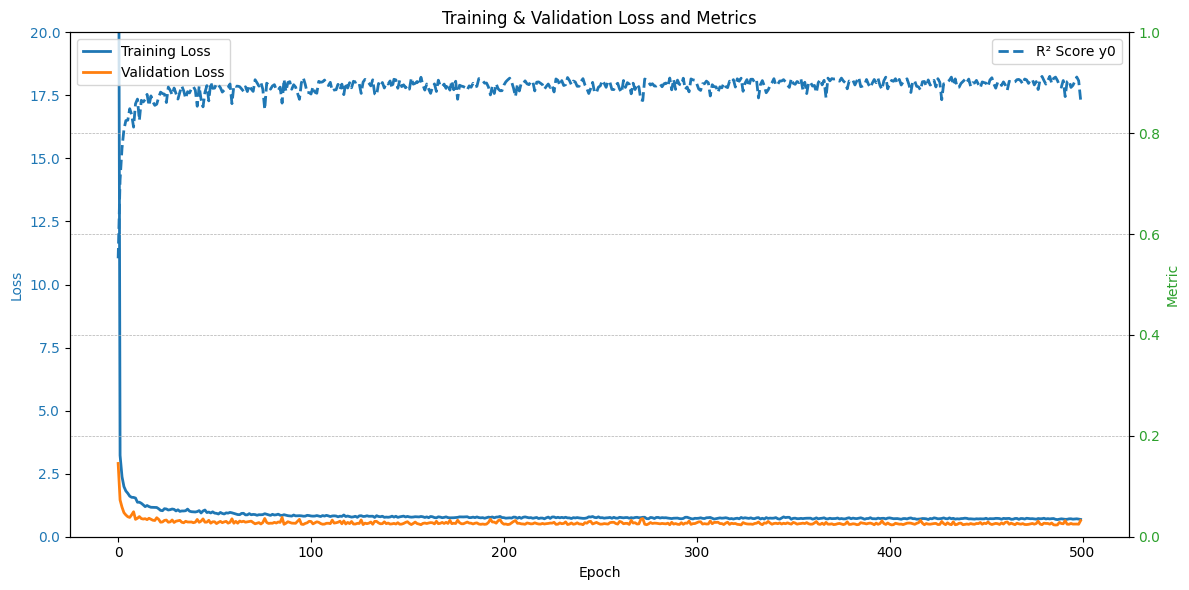

Training: filter_size=3, learning_rate=0.001, dropout=0.01
Saving best model to /home/klamdibih/Deep-Chemometrics/models/Darionet_Mango_uncertainty_best.pth
Epoch 1/500 | Train Loss: 23.2765 | Val Loss: 1.9057 | Val Mean Metrics: 0.6235
Model saved at epoch 0 to /home/klamdibih/Deep-Chemometrics/models/Darionet_Mango_uncertainty_best.pth
Model saved at epoch 0 to /home/klamdibih/Deep-Chemometrics/models/Darionet_Mango_uncertainty_best.pth
Epoch 2/500 | Train Loss: 1.8165 | Val Loss: 1.1764 | Val Mean Metrics: 0.7443
Model saved at epoch 1 to /home/klamdibih/Deep-Chemometrics/models/Darionet_Mango_uncertainty_best.pth
Epoch 3/500 | Train Loss: 1.4855 | Val Loss: 0.9682 | Val Mean Metrics: 0.7862
Model saved at epoch 2 to /home/klamdibih/Deep-Chemometrics/models/Darionet_Mango_uncertainty_best.pth
Epoch 4/500 | Train Loss: 1.3199 | Val Loss: 0.8846 | Val Mean Metrics: 0.8419
Model saved at epoch 3 to /home/klamdibih/Deep-Chemometrics/models/Darionet_Mango_uncertainty_best.pth
Epoch 5/500

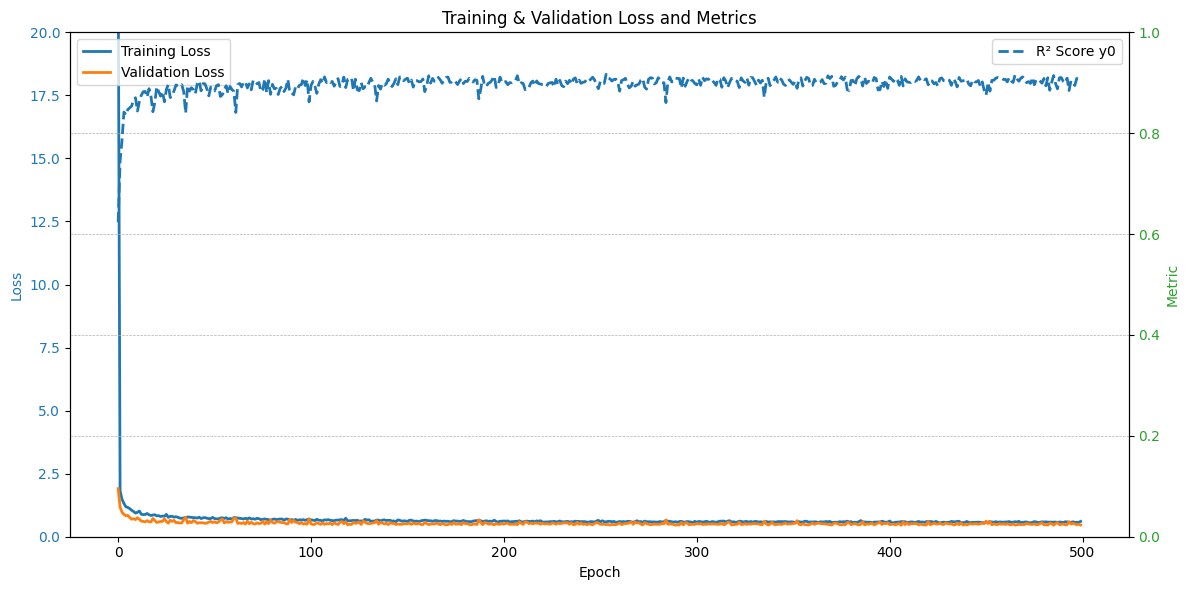

Training: filter_size=3, learning_rate=0.001, dropout=0.1
Saving best model to /home/klamdibih/Deep-Chemometrics/models/Darionet_Mango_uncertainty_best.pth
Epoch 1/500 | Train Loss: 39.3373 | Val Loss: 3.0331 | Val Mean Metrics: 0.4758
Model saved at epoch 0 to /home/klamdibih/Deep-Chemometrics/models/Darionet_Mango_uncertainty_best.pth
Model saved at epoch 0 to /home/klamdibih/Deep-Chemometrics/models/Darionet_Mango_uncertainty_best.pth
Epoch 2/500 | Train Loss: 7.2461 | Val Loss: 1.8725 | Val Mean Metrics: 0.5829
Model saved at epoch 1 to /home/klamdibih/Deep-Chemometrics/models/Darionet_Mango_uncertainty_best.pth
Epoch 3/500 | Train Loss: 5.6270 | Val Loss: 1.2631 | Val Mean Metrics: 0.7744
Model saved at epoch 2 to /home/klamdibih/Deep-Chemometrics/models/Darionet_Mango_uncertainty_best.pth
Epoch 4/500 | Train Loss: 4.9988 | Val Loss: 1.1412 | Val Mean Metrics: 0.7817
Model saved at epoch 3 to /home/klamdibih/Deep-Chemometrics/models/Darionet_Mango_uncertainty_best.pth
Epoch 5/500 

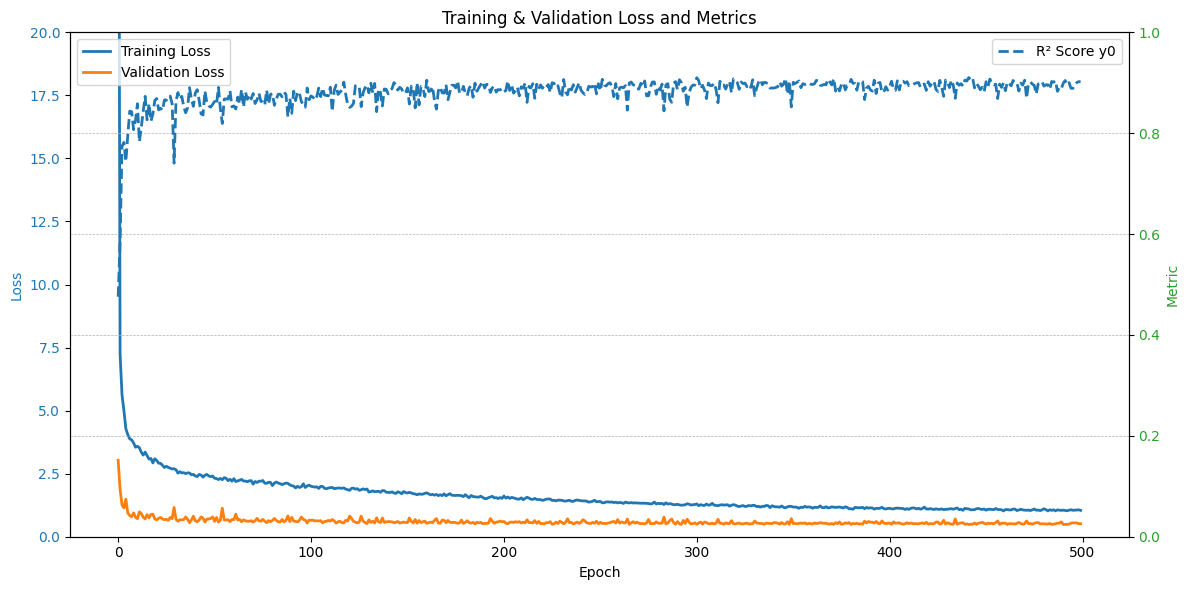

Training: filter_size=3, learning_rate=0.001, dropout=0.2
Saving best model to /home/klamdibih/Deep-Chemometrics/models/Darionet_Mango_uncertainty_best.pth
Epoch 1/500 | Train Loss: 109.7526 | Val Loss: 13.4832 | Val Mean Metrics: -0.6211
Model saved at epoch 0 to /home/klamdibih/Deep-Chemometrics/models/Darionet_Mango_uncertainty_best.pth
Epoch 2/500 | Train Loss: 18.3648 | Val Loss: 3.7558 | Val Mean Metrics: 0.3786
Model saved at epoch 1 to /home/klamdibih/Deep-Chemometrics/models/Darionet_Mango_uncertainty_best.pth
Model saved at epoch 1 to /home/klamdibih/Deep-Chemometrics/models/Darionet_Mango_uncertainty_best.pth
Epoch 3/500 | Train Loss: 13.5961 | Val Loss: 2.2929 | Val Mean Metrics: 0.5984
Model saved at epoch 2 to /home/klamdibih/Deep-Chemometrics/models/Darionet_Mango_uncertainty_best.pth
Epoch 4/500 | Train Loss: 11.5883 | Val Loss: 2.1327 | Val Mean Metrics: 0.5763
Epoch 5/500 | Train Loss: 11.2189 | Val Loss: 1.5314 | Val Mean Metrics: 0.6427
Model saved at epoch 4 to /ho

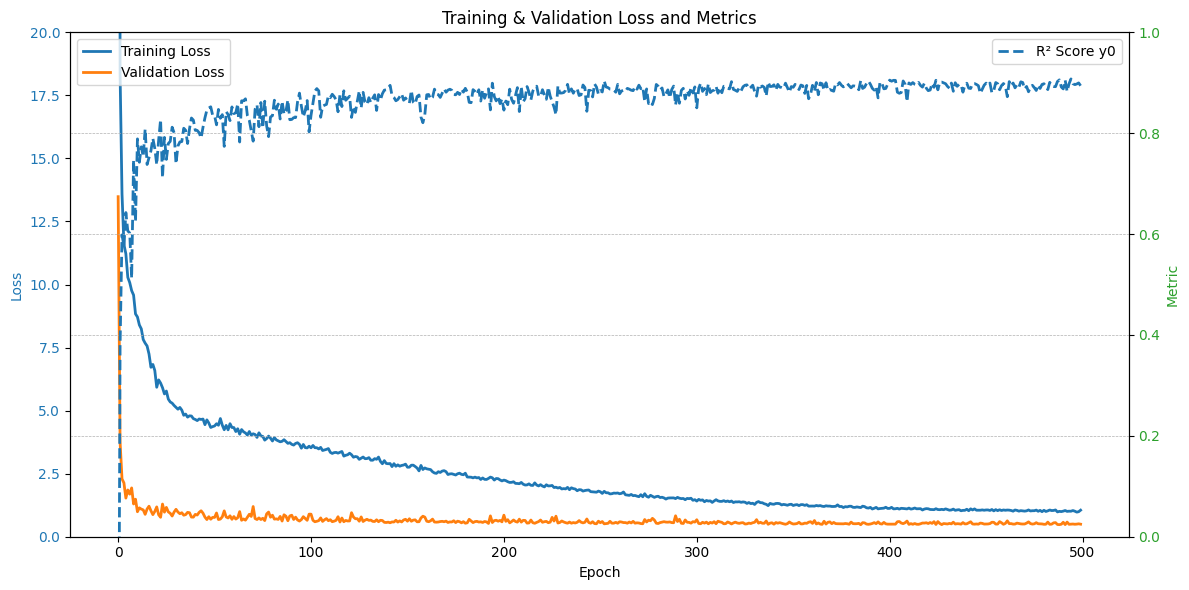

Training: filter_size=3, learning_rate=0.01, dropout=0.02
Saving best model to /home/klamdibih/Deep-Chemometrics/models/Darionet_Mango_uncertainty_best.pth
Epoch 1/500 | Train Loss: 21.6288 | Val Loss: 1.4675 | Val Mean Metrics: 0.6792
Model saved at epoch 0 to /home/klamdibih/Deep-Chemometrics/models/Darionet_Mango_uncertainty_best.pth
Model saved at epoch 0 to /home/klamdibih/Deep-Chemometrics/models/Darionet_Mango_uncertainty_best.pth
Epoch 2/500 | Train Loss: 1.9496 | Val Loss: 0.8643 | Val Mean Metrics: 0.8180
Model saved at epoch 1 to /home/klamdibih/Deep-Chemometrics/models/Darionet_Mango_uncertainty_best.pth
Epoch 3/500 | Train Loss: 1.6218 | Val Loss: 0.8616 | Val Mean Metrics: 0.8098
Epoch 4/500 | Train Loss: 1.5092 | Val Loss: 0.7680 | Val Mean Metrics: 0.8430
Model saved at epoch 3 to /home/klamdibih/Deep-Chemometrics/models/Darionet_Mango_uncertainty_best.pth
Epoch 5/500 | Train Loss: 1.4415 | Val Loss: 0.9851 | Val Mean Metrics: 0.7948
Epoch 6/500 | Train Loss: 1.4056 | V

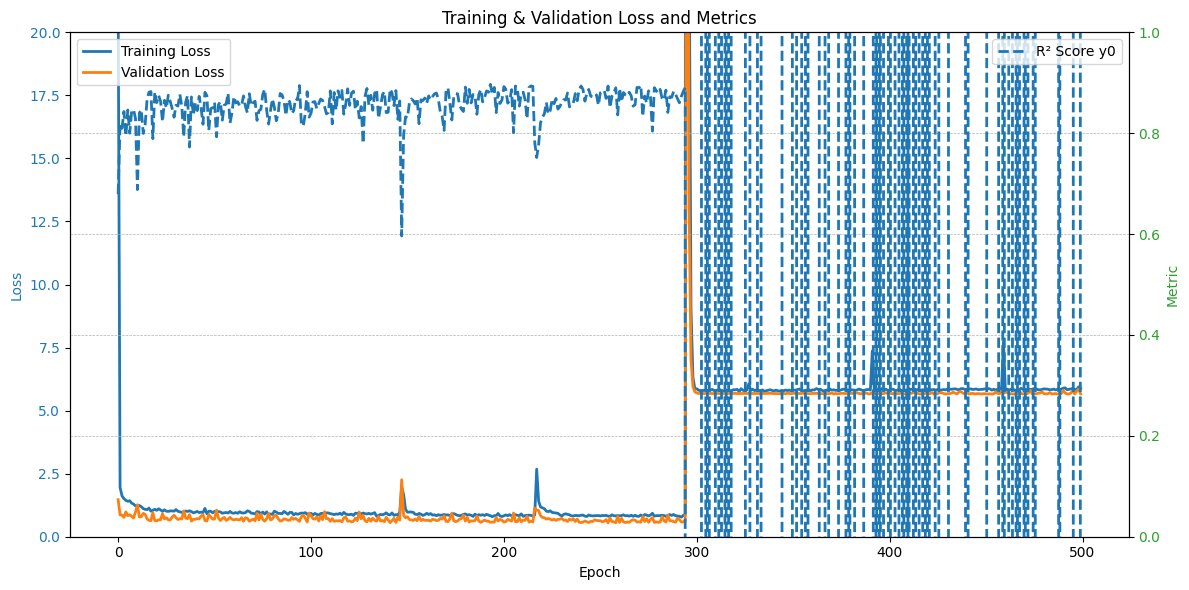

Training: filter_size=3, learning_rate=0.01, dropout=0.01
Saving best model to /home/klamdibih/Deep-Chemometrics/models/Darionet_Mango_uncertainty_best.pth
Epoch 1/500 | Train Loss: 17.0708 | Val Loss: 1.0842 | Val Mean Metrics: 0.7521
Model saved at epoch 0 to /home/klamdibih/Deep-Chemometrics/models/Darionet_Mango_uncertainty_best.pth
Model saved at epoch 0 to /home/klamdibih/Deep-Chemometrics/models/Darionet_Mango_uncertainty_best.pth
Epoch 2/500 | Train Loss: 1.6774 | Val Loss: 0.8210 | Val Mean Metrics: 0.8323
Model saved at epoch 1 to /home/klamdibih/Deep-Chemometrics/models/Darionet_Mango_uncertainty_best.pth
Epoch 3/500 | Train Loss: 1.4063 | Val Loss: 0.8565 | Val Mean Metrics: 0.8308
Epoch 4/500 | Train Loss: 1.1536 | Val Loss: 0.7325 | Val Mean Metrics: 0.8337
Model saved at epoch 3 to /home/klamdibih/Deep-Chemometrics/models/Darionet_Mango_uncertainty_best.pth
Epoch 5/500 | Train Loss: 1.1909 | Val Loss: 0.7458 | Val Mean Metrics: 0.8508
Model saved at epoch 4 to /home/klam

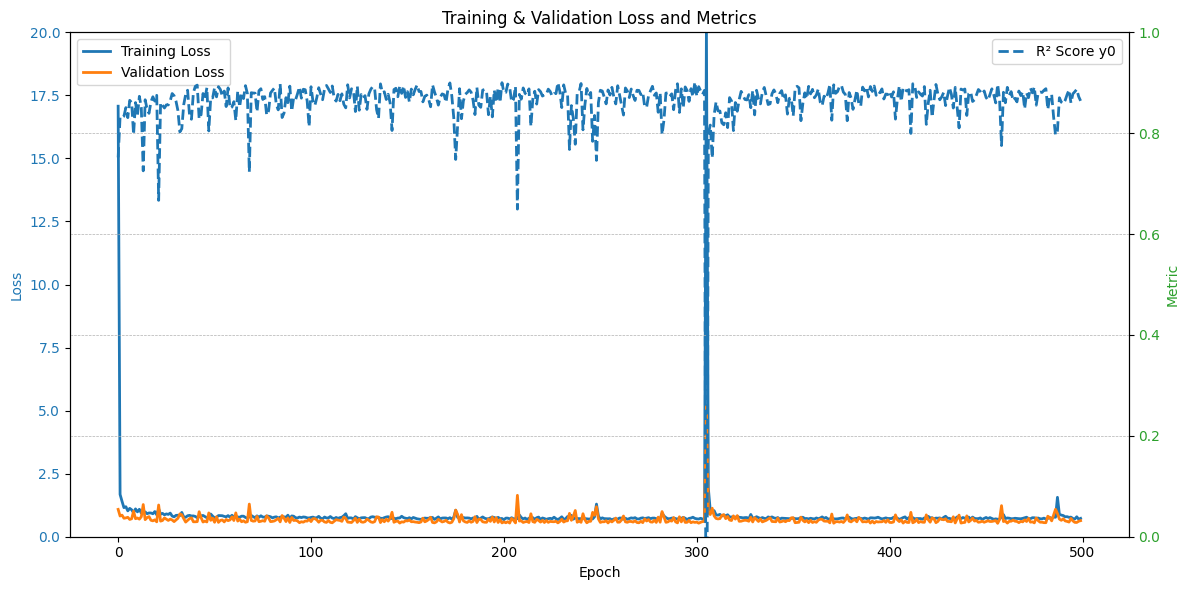

Training: filter_size=3, learning_rate=0.01, dropout=0.1
Saving best model to /home/klamdibih/Deep-Chemometrics/models/Darionet_Mango_uncertainty_best.pth
Epoch 1/500 | Train Loss: 17.3410 | Val Loss: 1.0369 | Val Mean Metrics: 0.8057
Model saved at epoch 0 to /home/klamdibih/Deep-Chemometrics/models/Darionet_Mango_uncertainty_best.pth
Model saved at epoch 0 to /home/klamdibih/Deep-Chemometrics/models/Darionet_Mango_uncertainty_best.pth
Epoch 2/500 | Train Loss: 3.7956 | Val Loss: 0.9639 | Val Mean Metrics: 0.8351
Model saved at epoch 1 to /home/klamdibih/Deep-Chemometrics/models/Darionet_Mango_uncertainty_best.pth
Epoch 3/500 | Train Loss: 3.4626 | Val Loss: 1.0201 | Val Mean Metrics: 0.7743
Epoch 4/500 | Train Loss: 3.0850 | Val Loss: 1.6674 | Val Mean Metrics: 0.5752
Epoch 5/500 | Train Loss: 2.9964 | Val Loss: 0.9450 | Val Mean Metrics: 0.7691
Epoch 6/500 | Train Loss: 2.9210 | Val Loss: 1.0516 | Val Mean Metrics: 0.7578
Epoch 7/500 | Train Loss: 2.7537 | Val Loss: 0.7888 | Val Mea

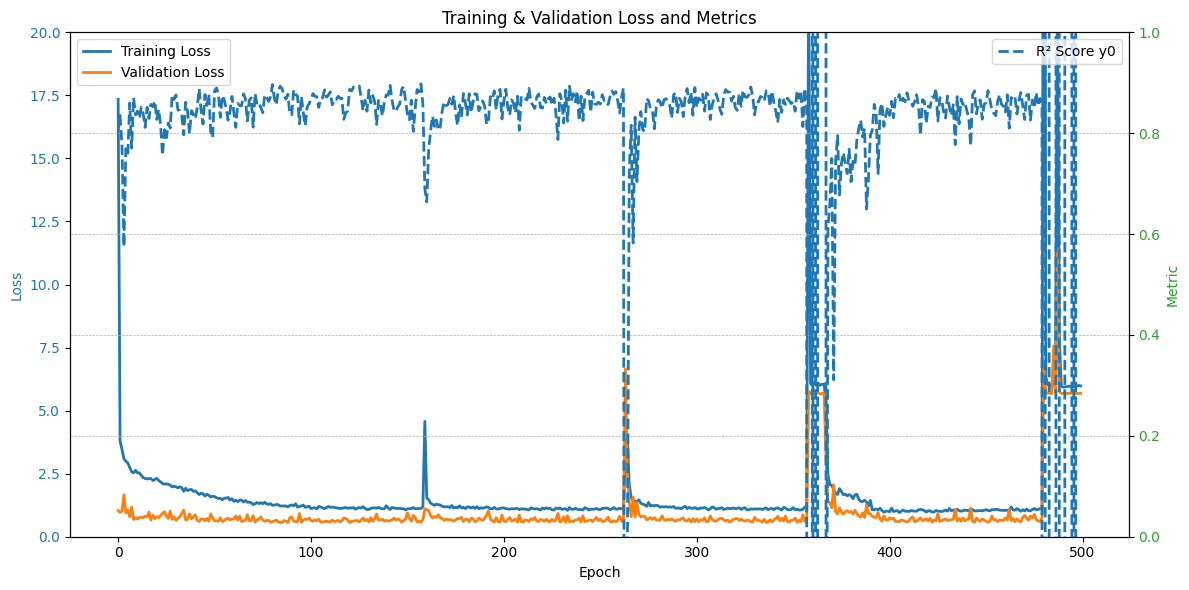

Training: filter_size=3, learning_rate=0.01, dropout=0.2
Saving best model to /home/klamdibih/Deep-Chemometrics/models/Darionet_Mango_uncertainty_best.pth
Epoch 1/500 | Train Loss: 26.7892 | Val Loss: 1.9887 | Val Mean Metrics: 0.4395
Model saved at epoch 0 to /home/klamdibih/Deep-Chemometrics/models/Darionet_Mango_uncertainty_best.pth
Model saved at epoch 0 to /home/klamdibih/Deep-Chemometrics/models/Darionet_Mango_uncertainty_best.pth
Epoch 2/500 | Train Loss: 6.3243 | Val Loss: 1.0384 | Val Mean Metrics: 0.7566
Model saved at epoch 1 to /home/klamdibih/Deep-Chemometrics/models/Darionet_Mango_uncertainty_best.pth
Epoch 3/500 | Train Loss: 5.7148 | Val Loss: 0.9244 | Val Mean Metrics: 0.7907
Model saved at epoch 2 to /home/klamdibih/Deep-Chemometrics/models/Darionet_Mango_uncertainty_best.pth
Epoch 4/500 | Train Loss: 5.5324 | Val Loss: 0.8184 | Val Mean Metrics: 0.8164
Model saved at epoch 3 to /home/klamdibih/Deep-Chemometrics/models/Darionet_Mango_uncertainty_best.pth
Epoch 5/500 |

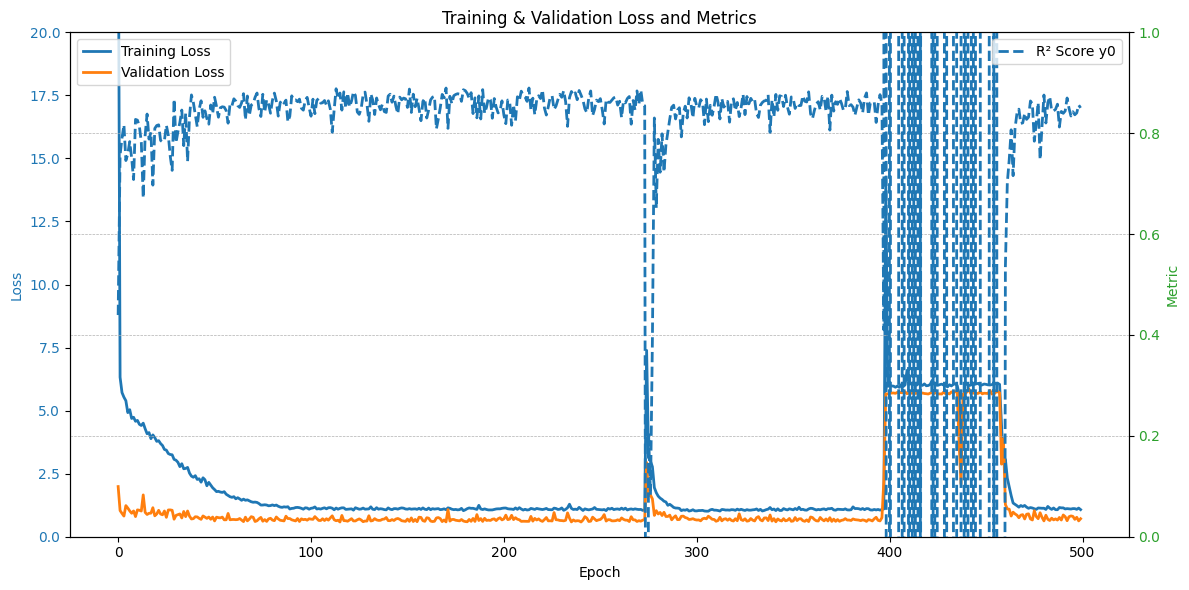

Training: filter_size=5, learning_rate=0.0001, dropout=0.02
Saving best model to /home/klamdibih/Deep-Chemometrics/models/Darionet_Mango_uncertainty_best.pth
Epoch 1/500 | Train Loss: 214.5280 | Val Loss: 166.8366 | Val Mean Metrics: -125.6832
Model saved at epoch 0 to /home/klamdibih/Deep-Chemometrics/models/Darionet_Mango_uncertainty_best.pth
Epoch 2/500 | Train Loss: 131.4356 | Val Loss: 99.2453 | Val Mean Metrics: -15.8253
Model saved at epoch 1 to /home/klamdibih/Deep-Chemometrics/models/Darionet_Mango_uncertainty_best.pth
Epoch 3/500 | Train Loss: 69.5570 | Val Loss: 42.6099 | Val Mean Metrics: -3.0266
Model saved at epoch 2 to /home/klamdibih/Deep-Chemometrics/models/Darionet_Mango_uncertainty_best.pth
Epoch 4/500 | Train Loss: 28.2540 | Val Loss: 18.3545 | Val Mean Metrics: -0.3992
Model saved at epoch 3 to /home/klamdibih/Deep-Chemometrics/models/Darionet_Mango_uncertainty_best.pth
Epoch 5/500 | Train Loss: 15.4890 | Val Loss: 10.9395 | Val Mean Metrics: -0.1963
Model saved at

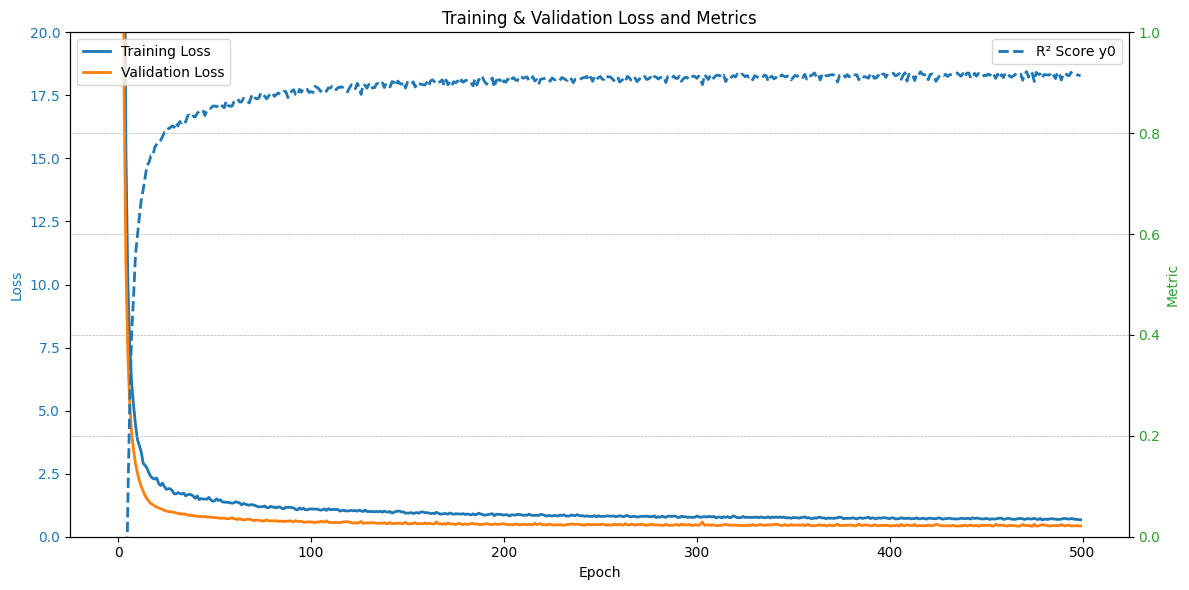

Training: filter_size=5, learning_rate=0.0001, dropout=0.01
Saving best model to /home/klamdibih/Deep-Chemometrics/models/Darionet_Mango_uncertainty_best.pth
Epoch 1/500 | Train Loss: 161.6892 | Val Loss: 80.1503 | Val Mean Metrics: -5.6373
Model saved at epoch 0 to /home/klamdibih/Deep-Chemometrics/models/Darionet_Mango_uncertainty_best.pth
Epoch 2/500 | Train Loss: 42.7639 | Val Loss: 20.7952 | Val Mean Metrics: -1.0240
Model saved at epoch 1 to /home/klamdibih/Deep-Chemometrics/models/Darionet_Mango_uncertainty_best.pth
Epoch 3/500 | Train Loss: 13.0824 | Val Loss: 8.1180 | Val Mean Metrics: -0.2744
Model saved at epoch 2 to /home/klamdibih/Deep-Chemometrics/models/Darionet_Mango_uncertainty_best.pth
Epoch 4/500 | Train Loss: 6.6789 | Val Loss: 4.9667 | Val Mean Metrics: 0.1466
Model saved at epoch 3 to /home/klamdibih/Deep-Chemometrics/models/Darionet_Mango_uncertainty_best.pth
Model saved at epoch 3 to /home/klamdibih/Deep-Chemometrics/models/Darionet_Mango_uncertainty_best.pth
Ep

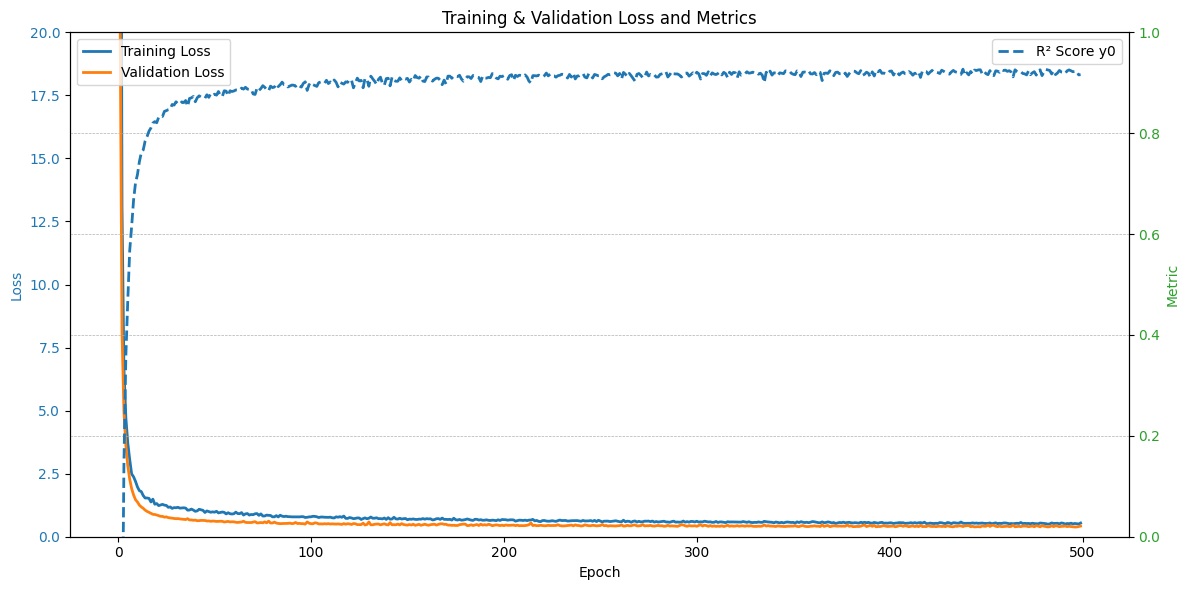

Training: filter_size=5, learning_rate=0.0001, dropout=0.1
Saving best model to /home/klamdibih/Deep-Chemometrics/models/Darionet_Mango_uncertainty_best.pth
Epoch 1/500 | Train Loss: 153.5854 | Val Loss: 63.2144 | Val Mean Metrics: -4.3662
Model saved at epoch 0 to /home/klamdibih/Deep-Chemometrics/models/Darionet_Mango_uncertainty_best.pth
Epoch 2/500 | Train Loss: 41.4233 | Val Loss: 19.1341 | Val Mean Metrics: -0.6097
Model saved at epoch 1 to /home/klamdibih/Deep-Chemometrics/models/Darionet_Mango_uncertainty_best.pth
Epoch 3/500 | Train Loss: 24.0224 | Val Loss: 10.7182 | Val Mean Metrics: -0.2609
Model saved at epoch 2 to /home/klamdibih/Deep-Chemometrics/models/Darionet_Mango_uncertainty_best.pth
Epoch 4/500 | Train Loss: 18.9779 | Val Loss: 6.9936 | Val Mean Metrics: 0.0460
Model saved at epoch 3 to /home/klamdibih/Deep-Chemometrics/models/Darionet_Mango_uncertainty_best.pth
Model saved at epoch 3 to /home/klamdibih/Deep-Chemometrics/models/Darionet_Mango_uncertainty_best.pth
E

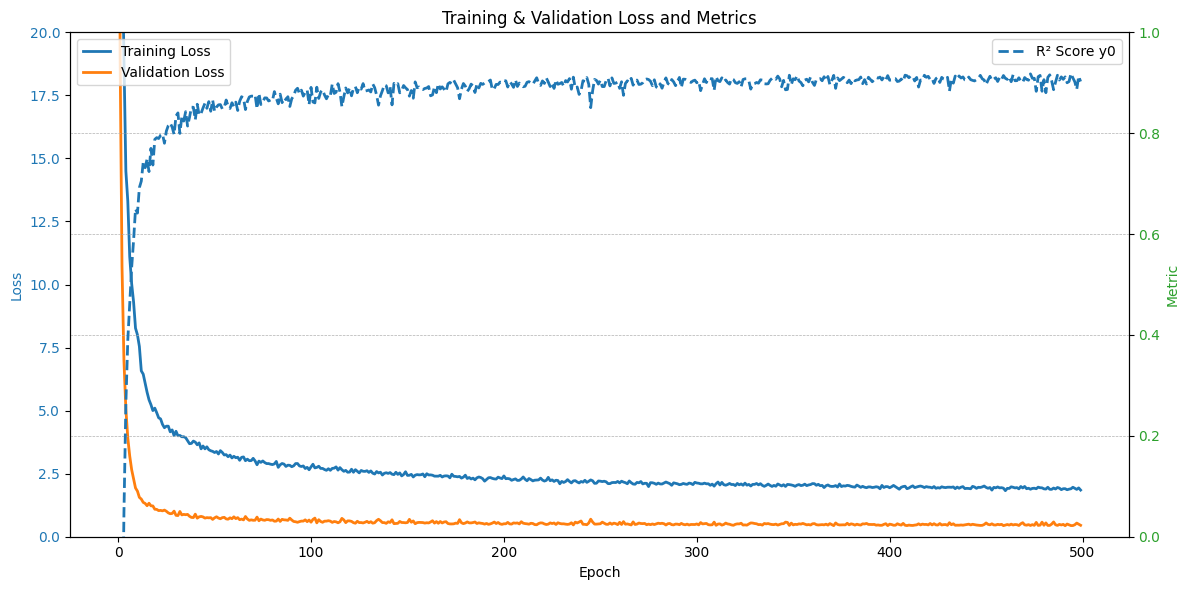

Training: filter_size=5, learning_rate=0.0001, dropout=0.2
Saving best model to /home/klamdibih/Deep-Chemometrics/models/Darionet_Mango_uncertainty_best.pth
Epoch 1/500 | Train Loss: 199.3973 | Val Loss: 127.7793 | Val Mean Metrics: -38.0300
Model saved at epoch 0 to /home/klamdibih/Deep-Chemometrics/models/Darionet_Mango_uncertainty_best.pth
Epoch 2/500 | Train Loss: 81.5093 | Val Loss: 39.1375 | Val Mean Metrics: -3.2610
Model saved at epoch 1 to /home/klamdibih/Deep-Chemometrics/models/Darionet_Mango_uncertainty_best.pth
Epoch 3/500 | Train Loss: 35.4987 | Val Loss: 14.8404 | Val Mean Metrics: -0.5664
Model saved at epoch 2 to /home/klamdibih/Deep-Chemometrics/models/Darionet_Mango_uncertainty_best.pth
Epoch 4/500 | Train Loss: 24.1722 | Val Loss: 9.3785 | Val Mean Metrics: -0.1620
Model saved at epoch 3 to /home/klamdibih/Deep-Chemometrics/models/Darionet_Mango_uncertainty_best.pth
Epoch 5/500 | Train Loss: 20.9535 | Val Loss: 7.1743 | Val Mean Metrics: 0.0148
Model saved at epoch 

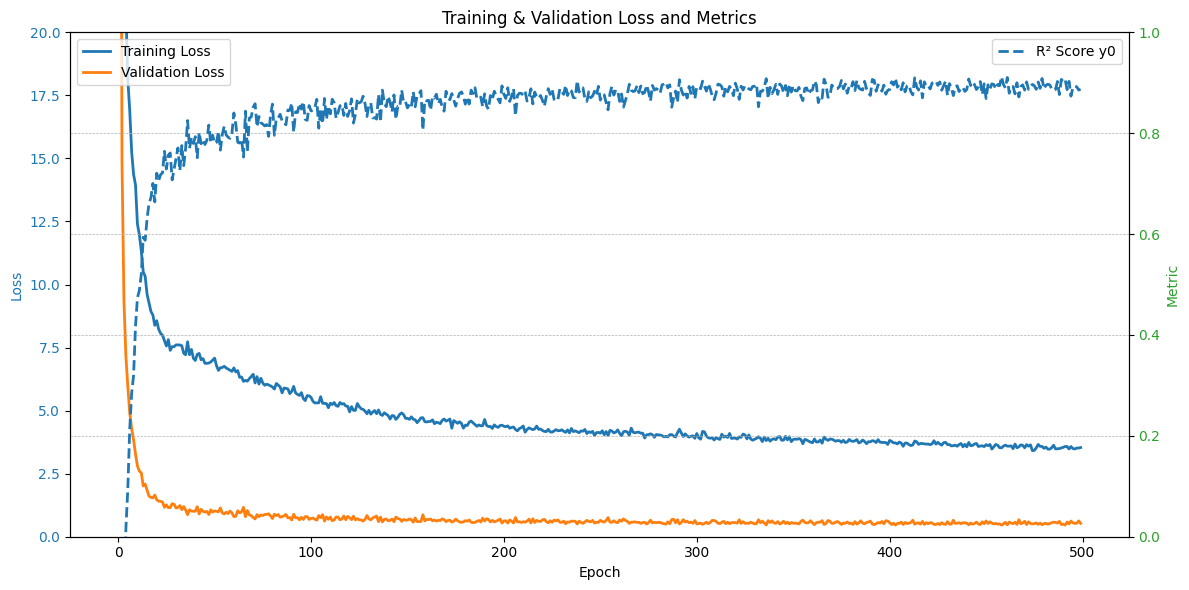

Training: filter_size=5, learning_rate=0.001, dropout=0.02
Saving best model to /home/klamdibih/Deep-Chemometrics/models/Darionet_Mango_uncertainty_best.pth
Epoch 1/500 | Train Loss: 73.3692 | Val Loss: 4.1528 | Val Mean Metrics: 0.3323
Model saved at epoch 0 to /home/klamdibih/Deep-Chemometrics/models/Darionet_Mango_uncertainty_best.pth
Model saved at epoch 0 to /home/klamdibih/Deep-Chemometrics/models/Darionet_Mango_uncertainty_best.pth
Epoch 2/500 | Train Loss: 4.6827 | Val Loss: 1.7700 | Val Mean Metrics: 0.6206
Model saved at epoch 1 to /home/klamdibih/Deep-Chemometrics/models/Darionet_Mango_uncertainty_best.pth
Epoch 3/500 | Train Loss: 3.0753 | Val Loss: 1.1932 | Val Mean Metrics: 0.7623
Model saved at epoch 2 to /home/klamdibih/Deep-Chemometrics/models/Darionet_Mango_uncertainty_best.pth
Epoch 4/500 | Train Loss: 2.1443 | Val Loss: 0.9266 | Val Mean Metrics: 0.8035
Model saved at epoch 3 to /home/klamdibih/Deep-Chemometrics/models/Darionet_Mango_uncertainty_best.pth
Epoch 5/500

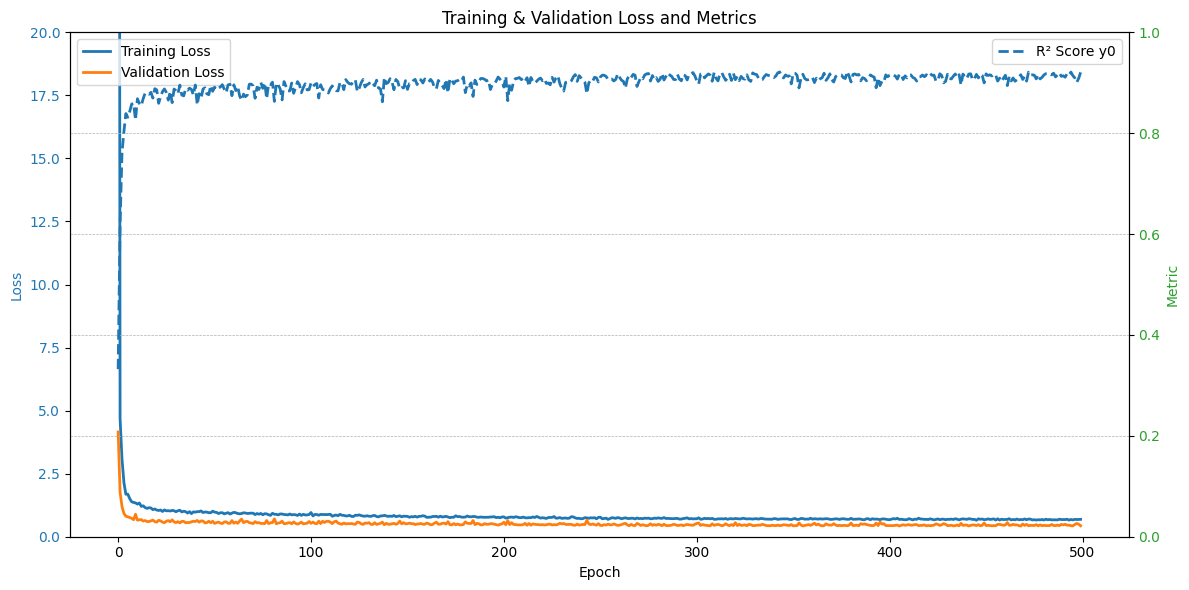

Training: filter_size=5, learning_rate=0.001, dropout=0.01
Saving best model to /home/klamdibih/Deep-Chemometrics/models/Darionet_Mango_uncertainty_best.pth
Epoch 1/500 | Train Loss: 37.8189 | Val Loss: 3.2447 | Val Mean Metrics: 0.5704
Model saved at epoch 0 to /home/klamdibih/Deep-Chemometrics/models/Darionet_Mango_uncertainty_best.pth
Model saved at epoch 0 to /home/klamdibih/Deep-Chemometrics/models/Darionet_Mango_uncertainty_best.pth
Epoch 2/500 | Train Loss: 2.6744 | Val Loss: 1.4813 | Val Mean Metrics: 0.7252
Model saved at epoch 1 to /home/klamdibih/Deep-Chemometrics/models/Darionet_Mango_uncertainty_best.pth
Epoch 3/500 | Train Loss: 1.5955 | Val Loss: 1.0165 | Val Mean Metrics: 0.8046
Model saved at epoch 2 to /home/klamdibih/Deep-Chemometrics/models/Darionet_Mango_uncertainty_best.pth
Epoch 4/500 | Train Loss: 1.3503 | Val Loss: 0.9003 | Val Mean Metrics: 0.8265
Model saved at epoch 3 to /home/klamdibih/Deep-Chemometrics/models/Darionet_Mango_uncertainty_best.pth
Epoch 5/500

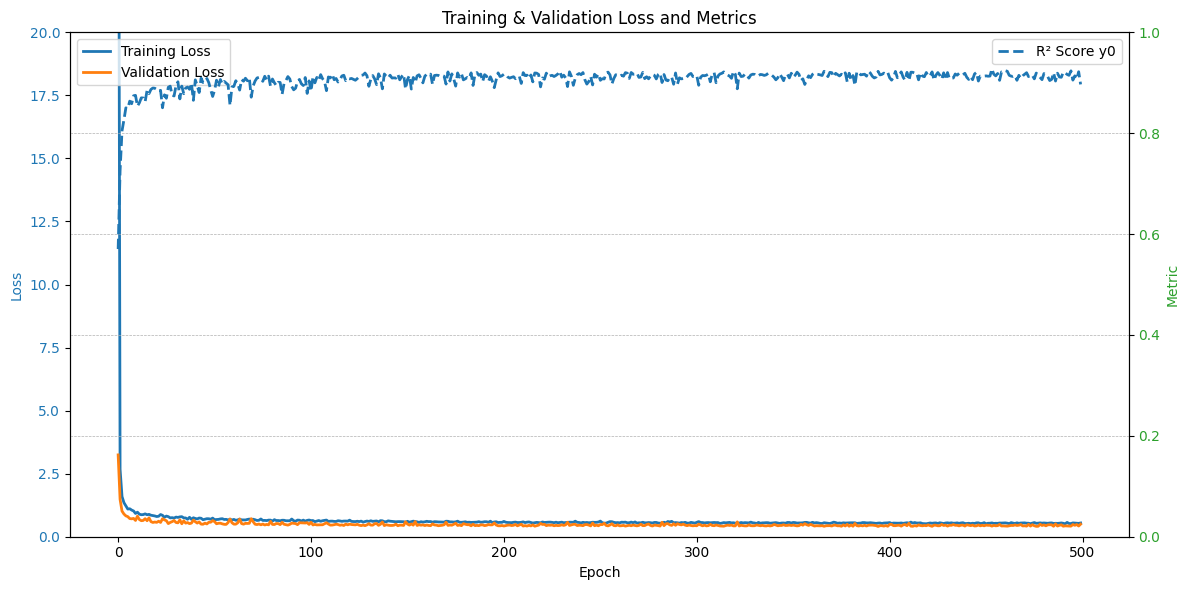

Training: filter_size=5, learning_rate=0.001, dropout=0.1
Saving best model to /home/klamdibih/Deep-Chemometrics/models/Darionet_Mango_uncertainty_best.pth
Epoch 1/500 | Train Loss: 31.7011 | Val Loss: 2.1233 | Val Mean Metrics: 0.5979
Model saved at epoch 0 to /home/klamdibih/Deep-Chemometrics/models/Darionet_Mango_uncertainty_best.pth
Model saved at epoch 0 to /home/klamdibih/Deep-Chemometrics/models/Darionet_Mango_uncertainty_best.pth
Epoch 2/500 | Train Loss: 6.5768 | Val Loss: 1.4824 | Val Mean Metrics: 0.6353
Model saved at epoch 1 to /home/klamdibih/Deep-Chemometrics/models/Darionet_Mango_uncertainty_best.pth
Epoch 3/500 | Train Loss: 4.8769 | Val Loss: 1.0261 | Val Mean Metrics: 0.8024
Model saved at epoch 2 to /home/klamdibih/Deep-Chemometrics/models/Darionet_Mango_uncertainty_best.pth
Epoch 4/500 | Train Loss: 4.3070 | Val Loss: 1.0384 | Val Mean Metrics: 0.7918
Epoch 5/500 | Train Loss: 4.1382 | Val Loss: 0.8607 | Val Mean Metrics: 0.8109
Model saved at epoch 4 to /home/klam

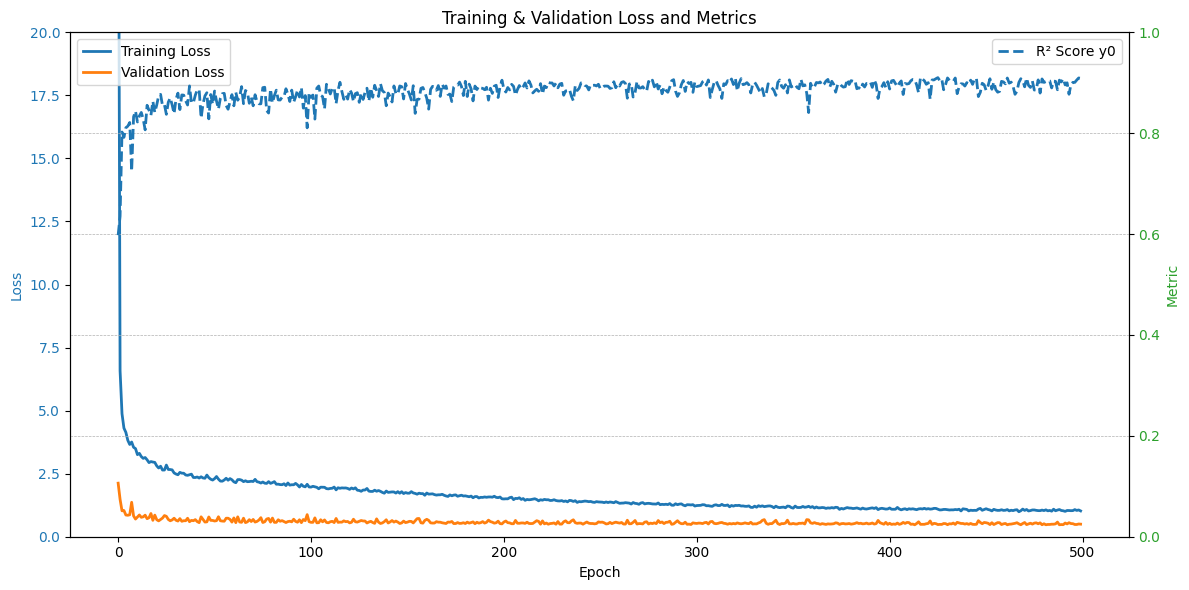

Training: filter_size=5, learning_rate=0.001, dropout=0.2
Saving best model to /home/klamdibih/Deep-Chemometrics/models/Darionet_Mango_uncertainty_best.pth
Epoch 1/500 | Train Loss: 31.8319 | Val Loss: 2.8739 | Val Mean Metrics: 0.5312
Model saved at epoch 0 to /home/klamdibih/Deep-Chemometrics/models/Darionet_Mango_uncertainty_best.pth
Model saved at epoch 0 to /home/klamdibih/Deep-Chemometrics/models/Darionet_Mango_uncertainty_best.pth
Epoch 2/500 | Train Loss: 10.0194 | Val Loss: 3.0956 | Val Mean Metrics: 0.2539
Epoch 3/500 | Train Loss: 7.5292 | Val Loss: 1.6306 | Val Mean Metrics: 0.6534
Model saved at epoch 2 to /home/klamdibih/Deep-Chemometrics/models/Darionet_Mango_uncertainty_best.pth
Epoch 4/500 | Train Loss: 6.7248 | Val Loss: 1.2019 | Val Mean Metrics: 0.7347
Model saved at epoch 3 to /home/klamdibih/Deep-Chemometrics/models/Darionet_Mango_uncertainty_best.pth
Epoch 5/500 | Train Loss: 5.9493 | Val Loss: 1.3814 | Val Mean Metrics: 0.7362
Model saved at epoch 4 to /home/kla

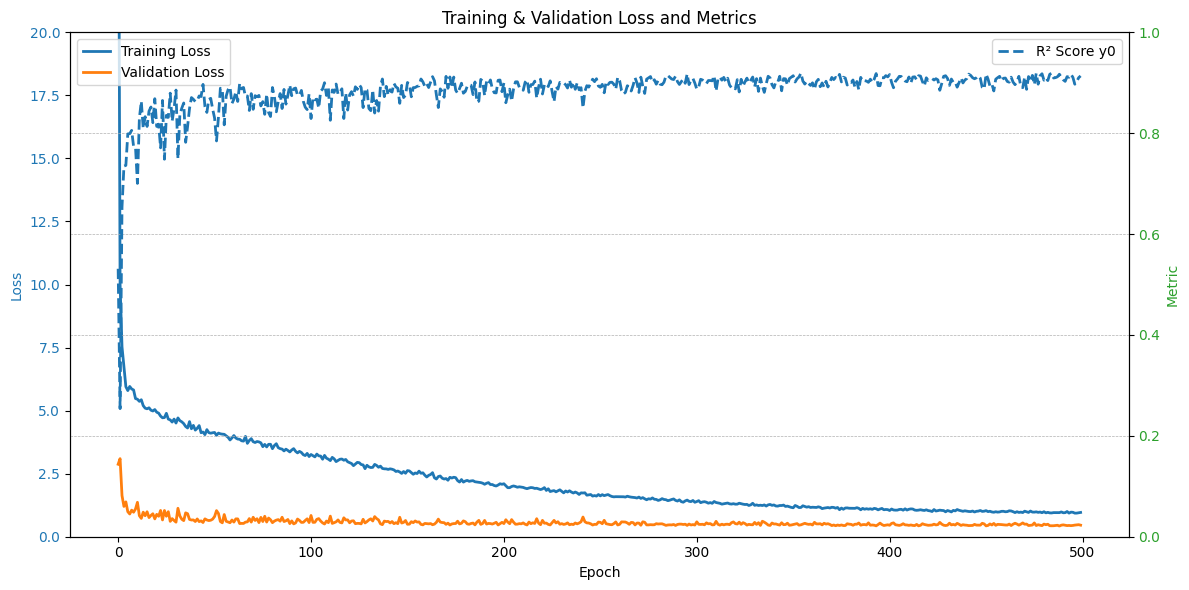

Training: filter_size=5, learning_rate=0.01, dropout=0.02
Saving best model to /home/klamdibih/Deep-Chemometrics/models/Darionet_Mango_uncertainty_best.pth
Epoch 1/500 | Train Loss: 40.2022 | Val Loss: 2.6070 | Val Mean Metrics: 0.5476
Model saved at epoch 0 to /home/klamdibih/Deep-Chemometrics/models/Darionet_Mango_uncertainty_best.pth
Model saved at epoch 0 to /home/klamdibih/Deep-Chemometrics/models/Darionet_Mango_uncertainty_best.pth
Epoch 2/500 | Train Loss: 3.3476 | Val Loss: 1.7449 | Val Mean Metrics: 0.6757
Model saved at epoch 1 to /home/klamdibih/Deep-Chemometrics/models/Darionet_Mango_uncertainty_best.pth
Epoch 3/500 | Train Loss: 2.6153 | Val Loss: 1.3424 | Val Mean Metrics: 0.7389
Model saved at epoch 2 to /home/klamdibih/Deep-Chemometrics/models/Darionet_Mango_uncertainty_best.pth
Epoch 4/500 | Train Loss: 2.2036 | Val Loss: 1.0952 | Val Mean Metrics: 0.7699
Model saved at epoch 3 to /home/klamdibih/Deep-Chemometrics/models/Darionet_Mango_uncertainty_best.pth
Epoch 5/500 

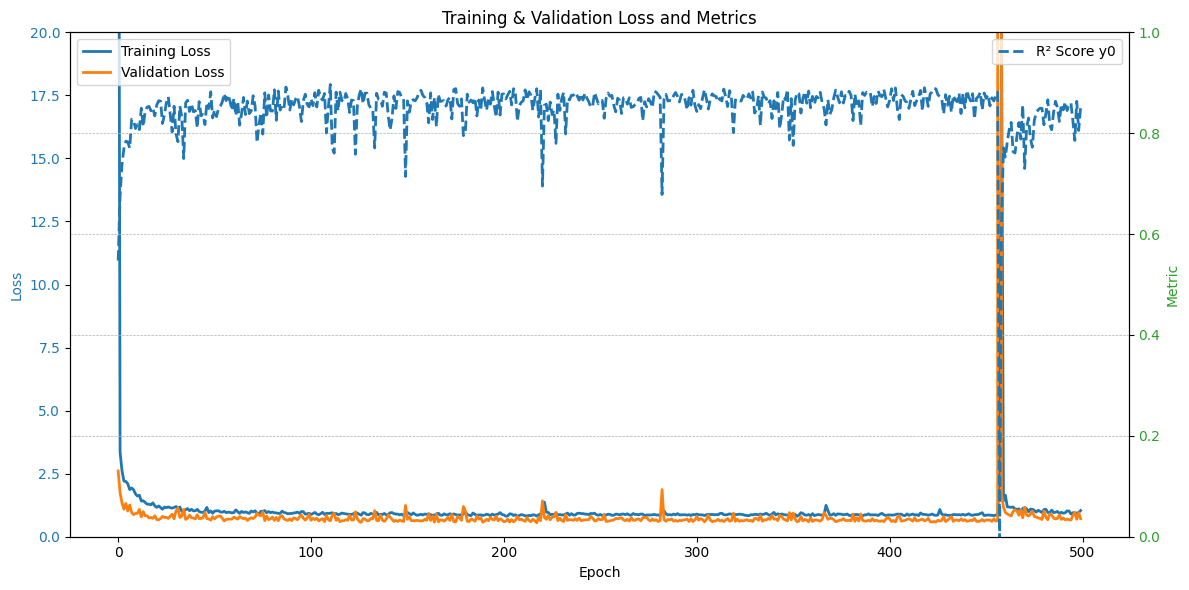

Training: filter_size=5, learning_rate=0.01, dropout=0.01
Saving best model to /home/klamdibih/Deep-Chemometrics/models/Darionet_Mango_uncertainty_best.pth
Epoch 1/500 | Train Loss: 16.2137 | Val Loss: 1.2416 | Val Mean Metrics: 0.7234
Model saved at epoch 0 to /home/klamdibih/Deep-Chemometrics/models/Darionet_Mango_uncertainty_best.pth
Model saved at epoch 0 to /home/klamdibih/Deep-Chemometrics/models/Darionet_Mango_uncertainty_best.pth
Epoch 2/500 | Train Loss: 1.7133 | Val Loss: 1.0009 | Val Mean Metrics: 0.8231
Model saved at epoch 1 to /home/klamdibih/Deep-Chemometrics/models/Darionet_Mango_uncertainty_best.pth
Epoch 3/500 | Train Loss: 1.4224 | Val Loss: 1.0611 | Val Mean Metrics: 0.7882
Epoch 4/500 | Train Loss: 1.2715 | Val Loss: 0.8786 | Val Mean Metrics: 0.8267
Model saved at epoch 3 to /home/klamdibih/Deep-Chemometrics/models/Darionet_Mango_uncertainty_best.pth
Epoch 5/500 | Train Loss: 1.2463 | Val Loss: 0.9291 | Val Mean Metrics: 0.7924
Epoch 6/500 | Train Loss: 1.1841 | V

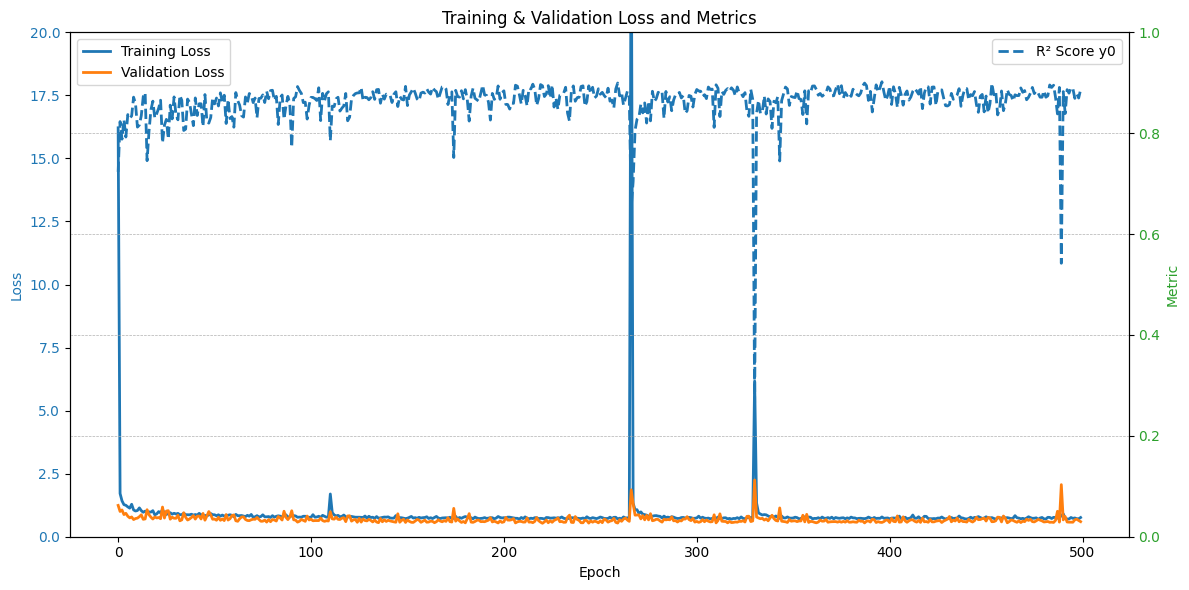

Training: filter_size=5, learning_rate=0.01, dropout=0.1
Saving best model to /home/klamdibih/Deep-Chemometrics/models/Darionet_Mango_uncertainty_best.pth
Epoch 1/500 | Train Loss: 23.7034 | Val Loss: 2.9970 | Val Mean Metrics: 0.3267
Model saved at epoch 0 to /home/klamdibih/Deep-Chemometrics/models/Darionet_Mango_uncertainty_best.pth
Model saved at epoch 0 to /home/klamdibih/Deep-Chemometrics/models/Darionet_Mango_uncertainty_best.pth
Epoch 2/500 | Train Loss: 4.7841 | Val Loss: 1.0397 | Val Mean Metrics: 0.7685
Model saved at epoch 1 to /home/klamdibih/Deep-Chemometrics/models/Darionet_Mango_uncertainty_best.pth
Epoch 3/500 | Train Loss: 4.1236 | Val Loss: 0.9862 | Val Mean Metrics: 0.8022
Model saved at epoch 2 to /home/klamdibih/Deep-Chemometrics/models/Darionet_Mango_uncertainty_best.pth
Epoch 4/500 | Train Loss: 3.3600 | Val Loss: 0.7823 | Val Mean Metrics: 0.8454
Model saved at epoch 3 to /home/klamdibih/Deep-Chemometrics/models/Darionet_Mango_uncertainty_best.pth
Epoch 5/500 |

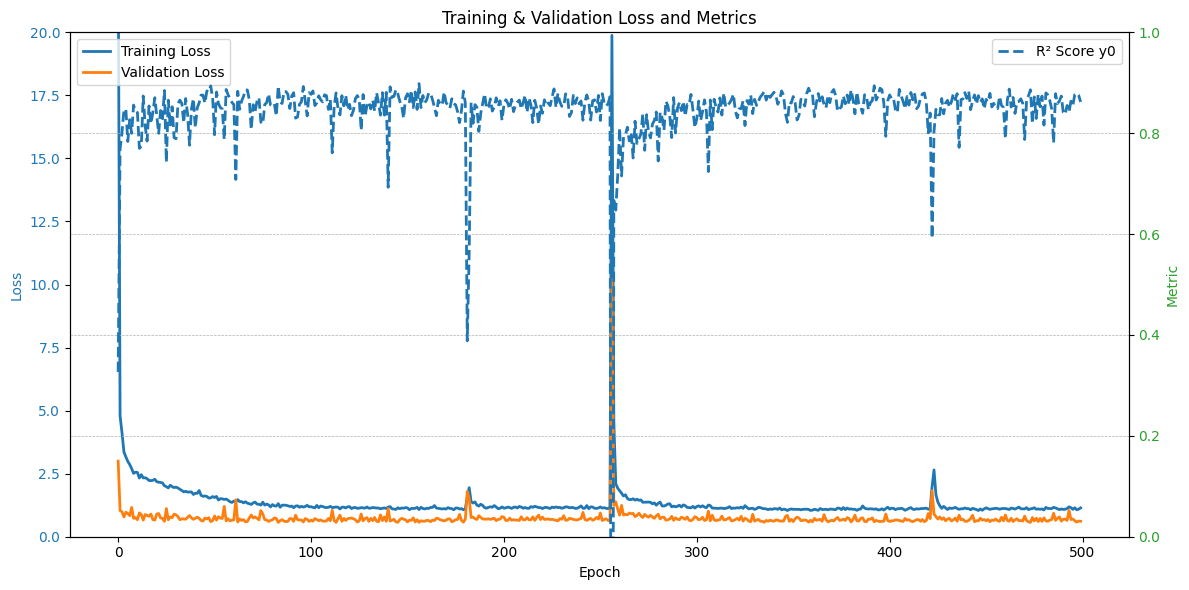

Training: filter_size=5, learning_rate=0.01, dropout=0.2
Saving best model to /home/klamdibih/Deep-Chemometrics/models/Darionet_Mango_uncertainty_best.pth
Epoch 1/500 | Train Loss: 28.0648 | Val Loss: 1.6375 | Val Mean Metrics: 0.6282
Model saved at epoch 0 to /home/klamdibih/Deep-Chemometrics/models/Darionet_Mango_uncertainty_best.pth
Model saved at epoch 0 to /home/klamdibih/Deep-Chemometrics/models/Darionet_Mango_uncertainty_best.pth
Epoch 2/500 | Train Loss: 6.1535 | Val Loss: 1.1242 | Val Mean Metrics: 0.7207
Model saved at epoch 1 to /home/klamdibih/Deep-Chemometrics/models/Darionet_Mango_uncertainty_best.pth
Epoch 3/500 | Train Loss: 5.5219 | Val Loss: 1.4494 | Val Mean Metrics: 0.7166
Epoch 4/500 | Train Loss: 5.4640 | Val Loss: 1.0528 | Val Mean Metrics: 0.8121
Model saved at epoch 3 to /home/klamdibih/Deep-Chemometrics/models/Darionet_Mango_uncertainty_best.pth
Epoch 5/500 | Train Loss: 4.9929 | Val Loss: 0.8208 | Val Mean Metrics: 0.8322
Model saved at epoch 4 to /home/klamd

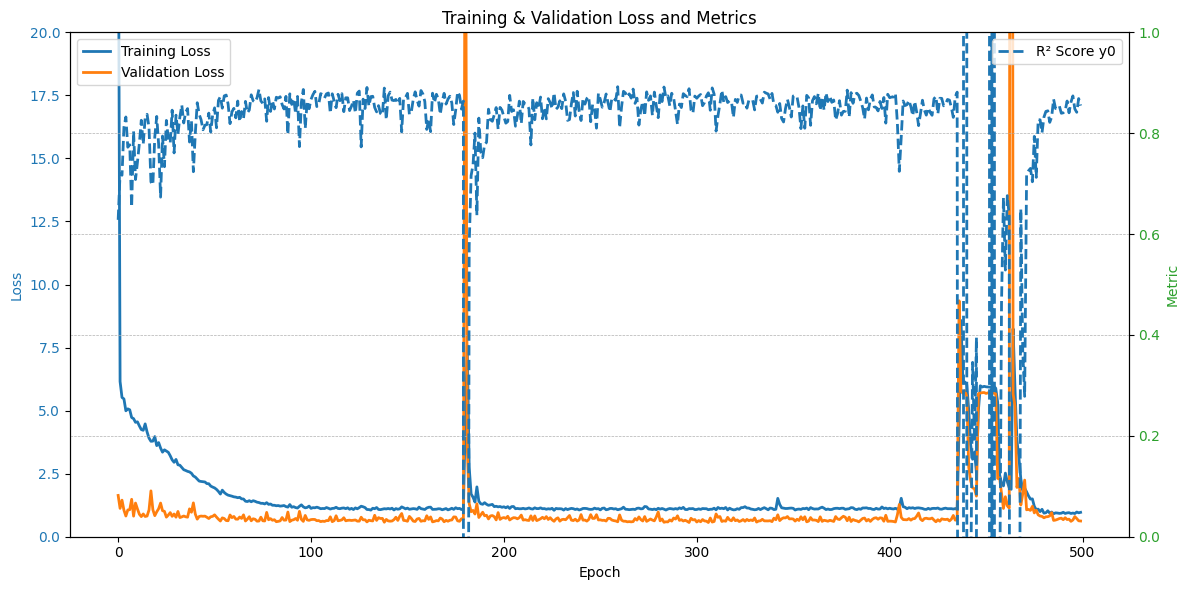

Training: filter_size=7, learning_rate=0.0001, dropout=0.02
Saving best model to /home/klamdibih/Deep-Chemometrics/models/Darionet_Mango_uncertainty_best.pth
Epoch 1/500 | Train Loss: 218.6907 | Val Loss: 162.9599 | Val Mean Metrics: -21.6097
Model saved at epoch 0 to /home/klamdibih/Deep-Chemometrics/models/Darionet_Mango_uncertainty_best.pth
Epoch 2/500 | Train Loss: 115.1123 | Val Loss: 76.7083 | Val Mean Metrics: -2.9310
Model saved at epoch 1 to /home/klamdibih/Deep-Chemometrics/models/Darionet_Mango_uncertainty_best.pth
Epoch 3/500 | Train Loss: 51.3902 | Val Loss: 28.7398 | Val Mean Metrics: -1.3190
Model saved at epoch 2 to /home/klamdibih/Deep-Chemometrics/models/Darionet_Mango_uncertainty_best.pth
Epoch 4/500 | Train Loss: 17.0180 | Val Loss: 7.6785 | Val Mean Metrics: 0.0872
Model saved at epoch 3 to /home/klamdibih/Deep-Chemometrics/models/Darionet_Mango_uncertainty_best.pth
Model saved at epoch 3 to /home/klamdibih/Deep-Chemometrics/models/Darionet_Mango_uncertainty_best.p

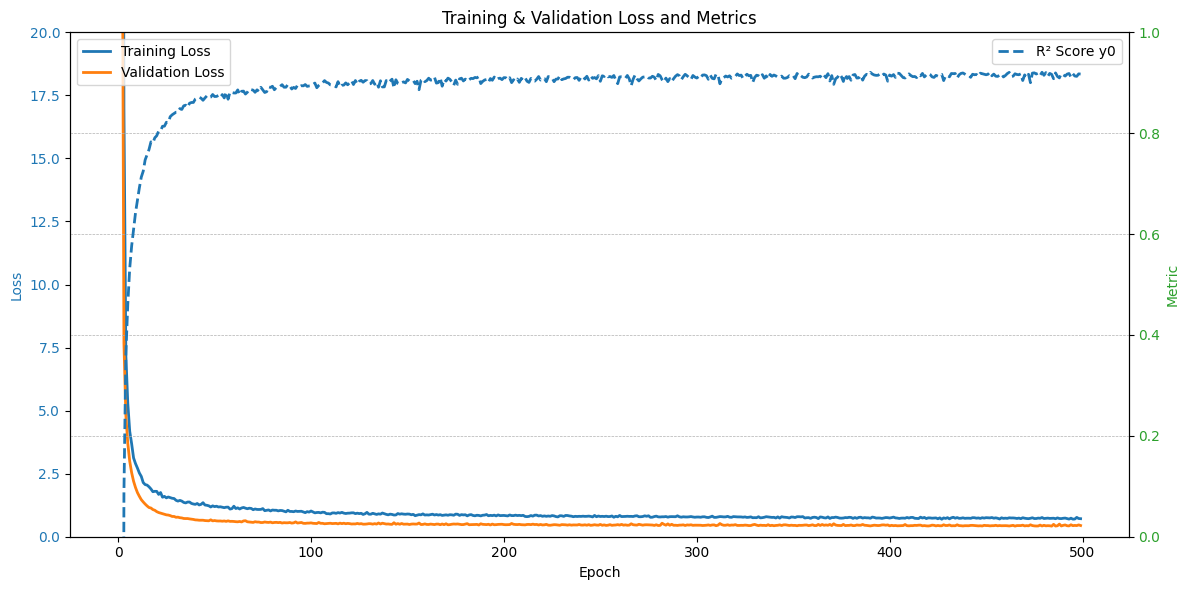

Training: filter_size=7, learning_rate=0.0001, dropout=0.01
Saving best model to /home/klamdibih/Deep-Chemometrics/models/Darionet_Mango_uncertainty_best.pth
Epoch 1/500 | Train Loss: 103.4044 | Val Loss: 32.6503 | Val Mean Metrics: -1.5181
Model saved at epoch 0 to /home/klamdibih/Deep-Chemometrics/models/Darionet_Mango_uncertainty_best.pth
Epoch 2/500 | Train Loss: 18.0039 | Val Loss: 9.2028 | Val Mean Metrics: -0.6219
Model saved at epoch 1 to /home/klamdibih/Deep-Chemometrics/models/Darionet_Mango_uncertainty_best.pth
Epoch 3/500 | Train Loss: 6.8628 | Val Loss: 4.4394 | Val Mean Metrics: 0.1041
Model saved at epoch 2 to /home/klamdibih/Deep-Chemometrics/models/Darionet_Mango_uncertainty_best.pth
Model saved at epoch 2 to /home/klamdibih/Deep-Chemometrics/models/Darionet_Mango_uncertainty_best.pth
Epoch 4/500 | Train Loss: 4.1447 | Val Loss: 2.8309 | Val Mean Metrics: 0.4578
Model saved at epoch 3 to /home/klamdibih/Deep-Chemometrics/models/Darionet_Mango_uncertainty_best.pth
Epoch

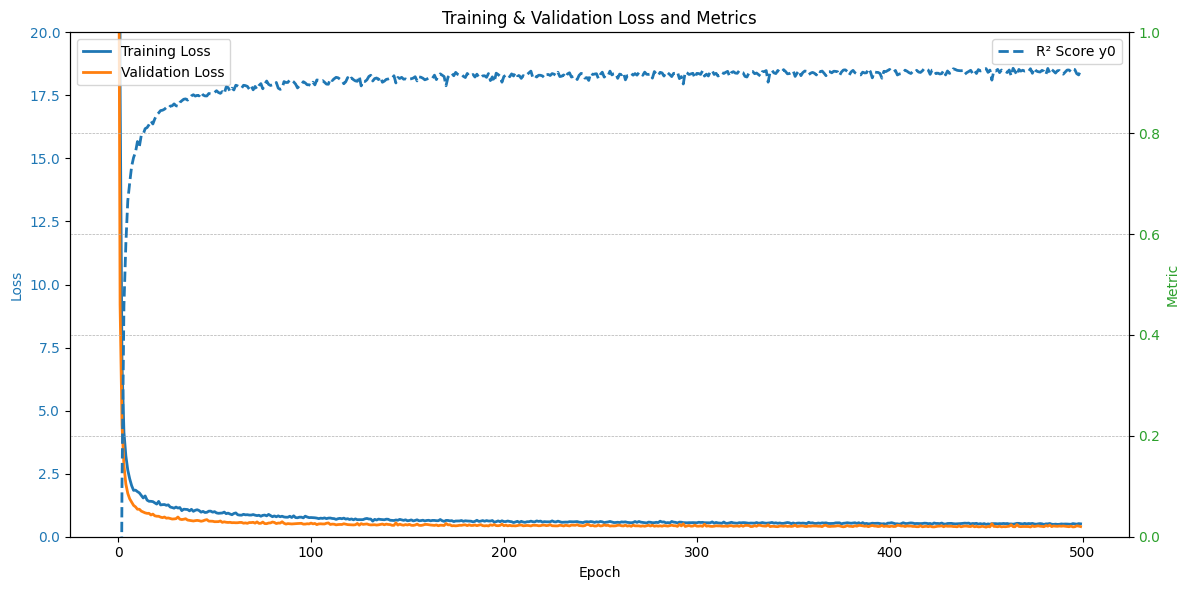

Training: filter_size=7, learning_rate=0.0001, dropout=0.1
Saving best model to /home/klamdibih/Deep-Chemometrics/models/Darionet_Mango_uncertainty_best.pth
Epoch 1/500 | Train Loss: 214.8595 | Val Loss: 159.0447 | Val Mean Metrics: -53.5765
Model saved at epoch 0 to /home/klamdibih/Deep-Chemometrics/models/Darionet_Mango_uncertainty_best.pth
Epoch 2/500 | Train Loss: 104.2973 | Val Loss: 59.1889 | Val Mean Metrics: -2.7637
Model saved at epoch 1 to /home/klamdibih/Deep-Chemometrics/models/Darionet_Mango_uncertainty_best.pth
Epoch 3/500 | Train Loss: 41.7309 | Val Loss: 23.8843 | Val Mean Metrics: -0.9367
Model saved at epoch 2 to /home/klamdibih/Deep-Chemometrics/models/Darionet_Mango_uncertainty_best.pth
Epoch 4/500 | Train Loss: 21.0604 | Val Loss: 10.8429 | Val Mean Metrics: -0.4876
Model saved at epoch 3 to /home/klamdibih/Deep-Chemometrics/models/Darionet_Mango_uncertainty_best.pth
Epoch 5/500 | Train Loss: 12.4092 | Val Loss: 5.5090 | Val Mean Metrics: -0.0173
Model saved at epo

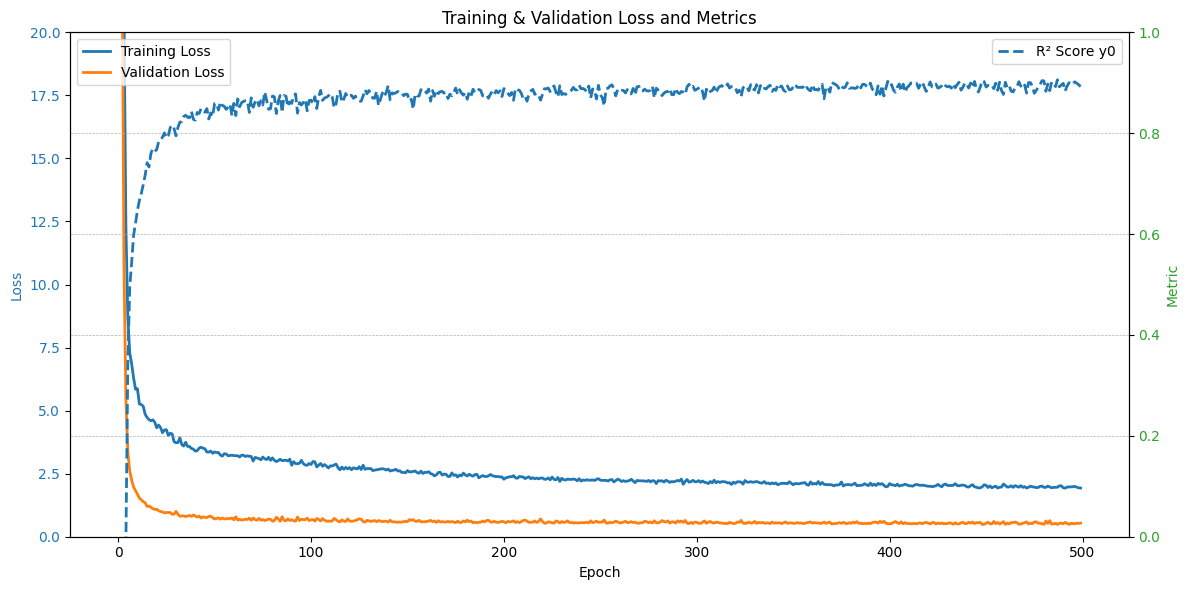

Training: filter_size=7, learning_rate=0.0001, dropout=0.2
Saving best model to /home/klamdibih/Deep-Chemometrics/models/Darionet_Mango_uncertainty_best.pth
Epoch 1/500 | Train Loss: 139.8135 | Val Loss: 46.2284 | Val Mean Metrics: -1.4880
Model saved at epoch 0 to /home/klamdibih/Deep-Chemometrics/models/Darionet_Mango_uncertainty_best.pth
Epoch 2/500 | Train Loss: 36.2268 | Val Loss: 14.3491 | Val Mean Metrics: -0.3571
Model saved at epoch 1 to /home/klamdibih/Deep-Chemometrics/models/Darionet_Mango_uncertainty_best.pth
Epoch 3/500 | Train Loss: 19.6949 | Val Loss: 7.6738 | Val Mean Metrics: -0.0018
Model saved at epoch 2 to /home/klamdibih/Deep-Chemometrics/models/Darionet_Mango_uncertainty_best.pth
Epoch 4/500 | Train Loss: 14.8986 | Val Loss: 5.1527 | Val Mean Metrics: 0.1890
Model saved at epoch 3 to /home/klamdibih/Deep-Chemometrics/models/Darionet_Mango_uncertainty_best.pth
Model saved at epoch 3 to /home/klamdibih/Deep-Chemometrics/models/Darionet_Mango_uncertainty_best.pth
Ep

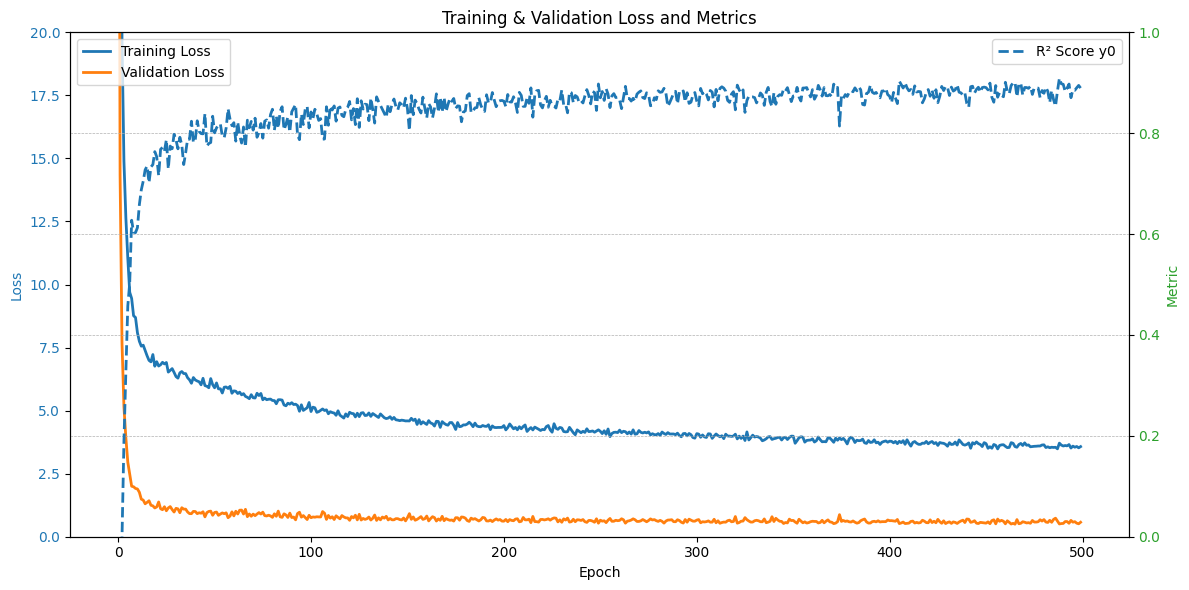

Training: filter_size=7, learning_rate=0.001, dropout=0.02
Saving best model to /home/klamdibih/Deep-Chemometrics/models/Darionet_Mango_uncertainty_best.pth
Epoch 1/500 | Train Loss: 17.8450 | Val Loss: 1.6362 | Val Mean Metrics: 0.6715
Model saved at epoch 0 to /home/klamdibih/Deep-Chemometrics/models/Darionet_Mango_uncertainty_best.pth
Model saved at epoch 0 to /home/klamdibih/Deep-Chemometrics/models/Darionet_Mango_uncertainty_best.pth
Epoch 2/500 | Train Loss: 2.5952 | Val Loss: 1.1060 | Val Mean Metrics: 0.7680
Model saved at epoch 1 to /home/klamdibih/Deep-Chemometrics/models/Darionet_Mango_uncertainty_best.pth
Epoch 3/500 | Train Loss: 2.0403 | Val Loss: 1.0534 | Val Mean Metrics: 0.7674
Epoch 4/500 | Train Loss: 1.7913 | Val Loss: 0.8343 | Val Mean Metrics: 0.8365
Model saved at epoch 3 to /home/klamdibih/Deep-Chemometrics/models/Darionet_Mango_uncertainty_best.pth
Epoch 5/500 | Train Loss: 1.5913 | Val Loss: 0.8451 | Val Mean Metrics: 0.8396
Model saved at epoch 4 to /home/kla

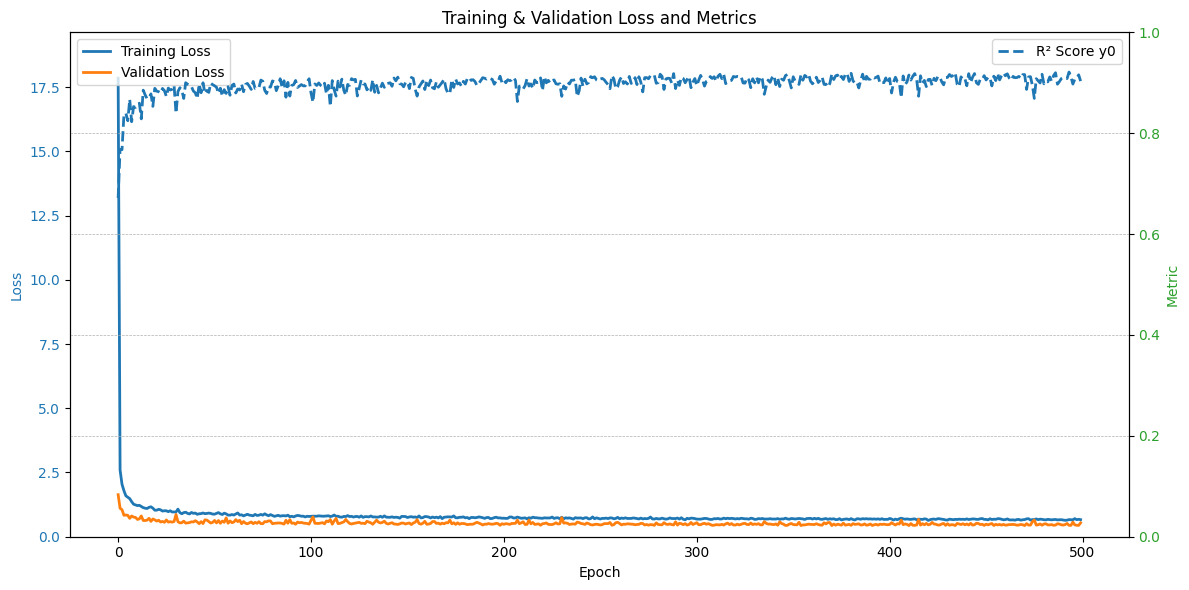

Training: filter_size=7, learning_rate=0.001, dropout=0.01
Saving best model to /home/klamdibih/Deep-Chemometrics/models/Darionet_Mango_uncertainty_best.pth
Epoch 1/500 | Train Loss: 41.4255 | Val Loss: 4.6664 | Val Mean Metrics: 0.3898
Model saved at epoch 0 to /home/klamdibih/Deep-Chemometrics/models/Darionet_Mango_uncertainty_best.pth
Model saved at epoch 0 to /home/klamdibih/Deep-Chemometrics/models/Darionet_Mango_uncertainty_best.pth
Epoch 2/500 | Train Loss: 3.3443 | Val Loss: 1.7810 | Val Mean Metrics: 0.7104
Model saved at epoch 1 to /home/klamdibih/Deep-Chemometrics/models/Darionet_Mango_uncertainty_best.pth
Epoch 3/500 | Train Loss: 1.8041 | Val Loss: 1.1623 | Val Mean Metrics: 0.7910
Model saved at epoch 2 to /home/klamdibih/Deep-Chemometrics/models/Darionet_Mango_uncertainty_best.pth
Epoch 4/500 | Train Loss: 1.4244 | Val Loss: 0.9435 | Val Mean Metrics: 0.8291
Model saved at epoch 3 to /home/klamdibih/Deep-Chemometrics/models/Darionet_Mango_uncertainty_best.pth
Epoch 5/500

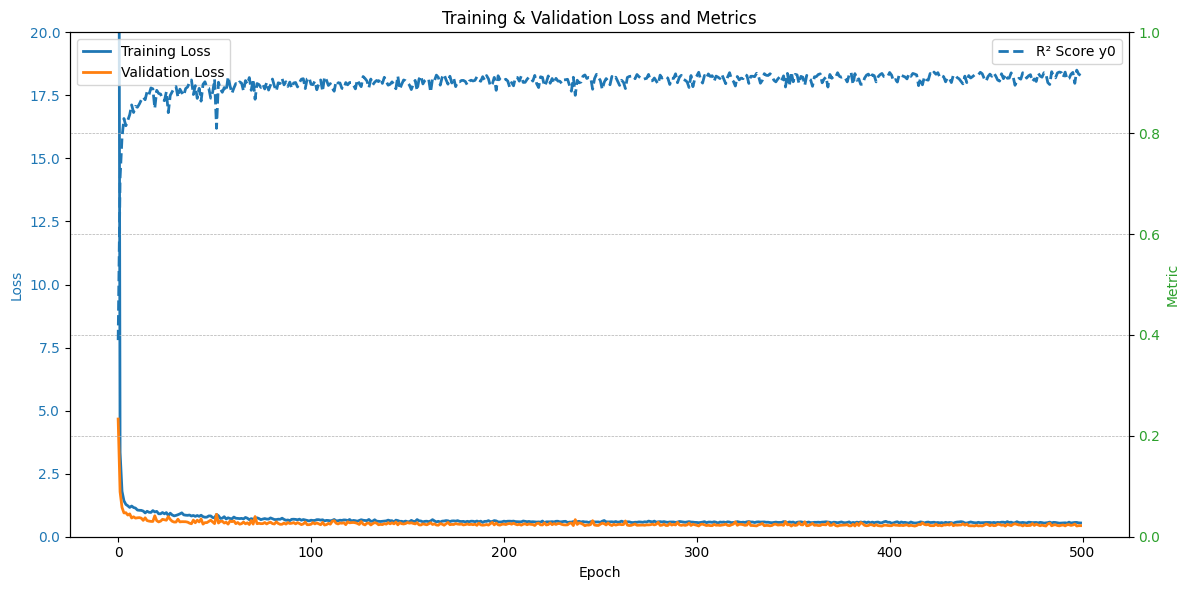

Training: filter_size=7, learning_rate=0.001, dropout=0.1
Saving best model to /home/klamdibih/Deep-Chemometrics/models/Darionet_Mango_uncertainty_best.pth
Epoch 1/500 | Train Loss: 47.5058 | Val Loss: 4.8505 | Val Mean Metrics: 0.2536
Model saved at epoch 0 to /home/klamdibih/Deep-Chemometrics/models/Darionet_Mango_uncertainty_best.pth
Model saved at epoch 0 to /home/klamdibih/Deep-Chemometrics/models/Darionet_Mango_uncertainty_best.pth
Epoch 2/500 | Train Loss: 6.0673 | Val Loss: 1.9079 | Val Mean Metrics: 0.6762
Model saved at epoch 1 to /home/klamdibih/Deep-Chemometrics/models/Darionet_Mango_uncertainty_best.pth
Epoch 3/500 | Train Loss: 4.4196 | Val Loss: 1.3352 | Val Mean Metrics: 0.7257
Model saved at epoch 2 to /home/klamdibih/Deep-Chemometrics/models/Darionet_Mango_uncertainty_best.pth
Epoch 4/500 | Train Loss: 3.6482 | Val Loss: 1.2279 | Val Mean Metrics: 0.7290
Model saved at epoch 3 to /home/klamdibih/Deep-Chemometrics/models/Darionet_Mango_uncertainty_best.pth
Epoch 5/500 

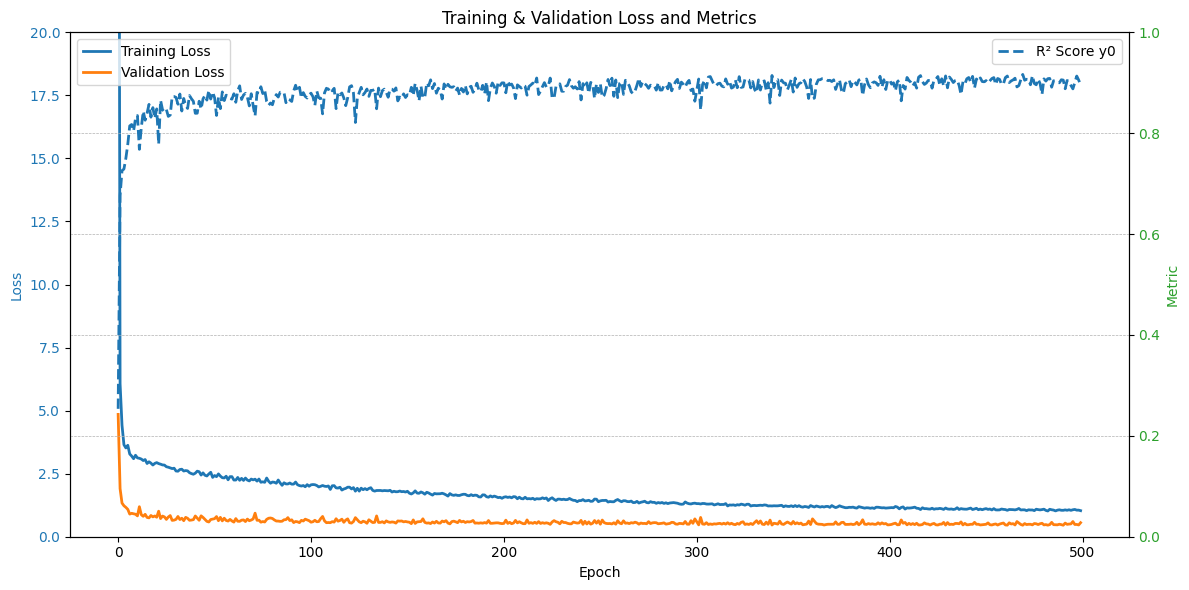

Training: filter_size=7, learning_rate=0.001, dropout=0.2
Saving best model to /home/klamdibih/Deep-Chemometrics/models/Darionet_Mango_uncertainty_best.pth
Epoch 1/500 | Train Loss: 36.9282 | Val Loss: 3.0332 | Val Mean Metrics: 0.4550
Model saved at epoch 0 to /home/klamdibih/Deep-Chemometrics/models/Darionet_Mango_uncertainty_best.pth
Model saved at epoch 0 to /home/klamdibih/Deep-Chemometrics/models/Darionet_Mango_uncertainty_best.pth
Epoch 2/500 | Train Loss: 10.4592 | Val Loss: 1.7992 | Val Mean Metrics: 0.7086
Model saved at epoch 1 to /home/klamdibih/Deep-Chemometrics/models/Darionet_Mango_uncertainty_best.pth
Epoch 3/500 | Train Loss: 7.8519 | Val Loss: 1.3241 | Val Mean Metrics: 0.7174
Model saved at epoch 2 to /home/klamdibih/Deep-Chemometrics/models/Darionet_Mango_uncertainty_best.pth
Epoch 4/500 | Train Loss: 7.4801 | Val Loss: 1.6422 | Val Mean Metrics: 0.6514
Epoch 5/500 | Train Loss: 7.1899 | Val Loss: 1.3818 | Val Mean Metrics: 0.7608
Model saved at epoch 4 to /home/kla

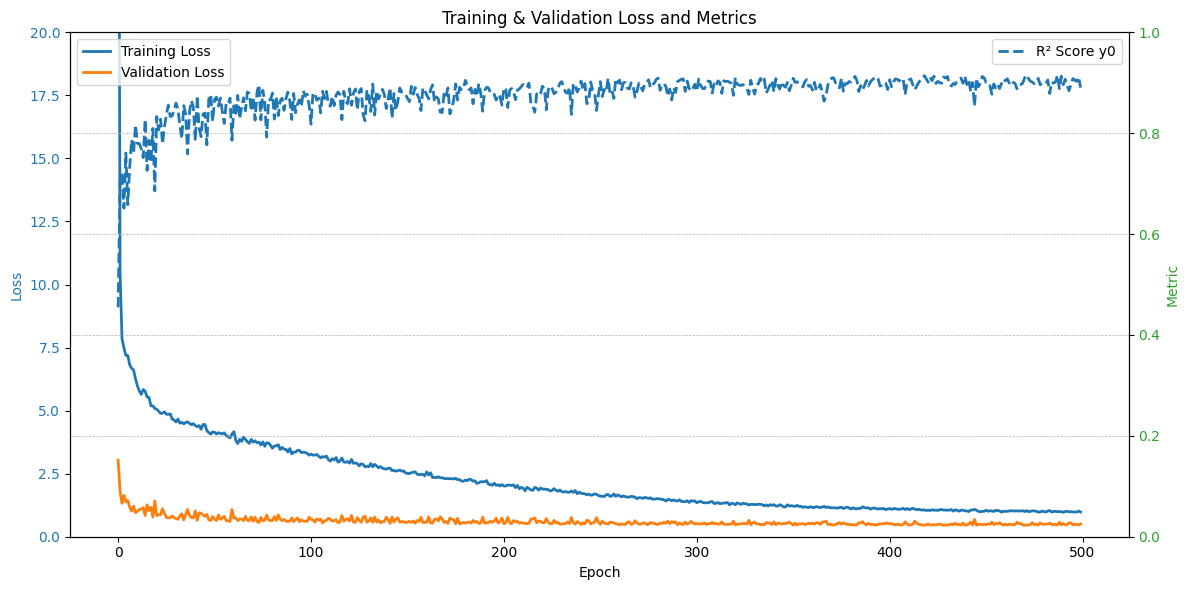

Training: filter_size=7, learning_rate=0.01, dropout=0.02
Saving best model to /home/klamdibih/Deep-Chemometrics/models/Darionet_Mango_uncertainty_best.pth
Epoch 1/500 | Train Loss: 13.7131 | Val Loss: 1.2444 | Val Mean Metrics: 0.7546
Model saved at epoch 0 to /home/klamdibih/Deep-Chemometrics/models/Darionet_Mango_uncertainty_best.pth
Model saved at epoch 0 to /home/klamdibih/Deep-Chemometrics/models/Darionet_Mango_uncertainty_best.pth
Epoch 2/500 | Train Loss: 1.6671 | Val Loss: 0.9605 | Val Mean Metrics: 0.8183
Model saved at epoch 1 to /home/klamdibih/Deep-Chemometrics/models/Darionet_Mango_uncertainty_best.pth
Epoch 3/500 | Train Loss: 1.3171 | Val Loss: 0.7300 | Val Mean Metrics: 0.8751
Model saved at epoch 2 to /home/klamdibih/Deep-Chemometrics/models/Darionet_Mango_uncertainty_best.pth
Epoch 4/500 | Train Loss: 1.3946 | Val Loss: 0.7425 | Val Mean Metrics: 0.8492
Epoch 5/500 | Train Loss: 1.1879 | Val Loss: 0.8275 | Val Mean Metrics: 0.8543
Epoch 6/500 | Train Loss: 1.2131 | V

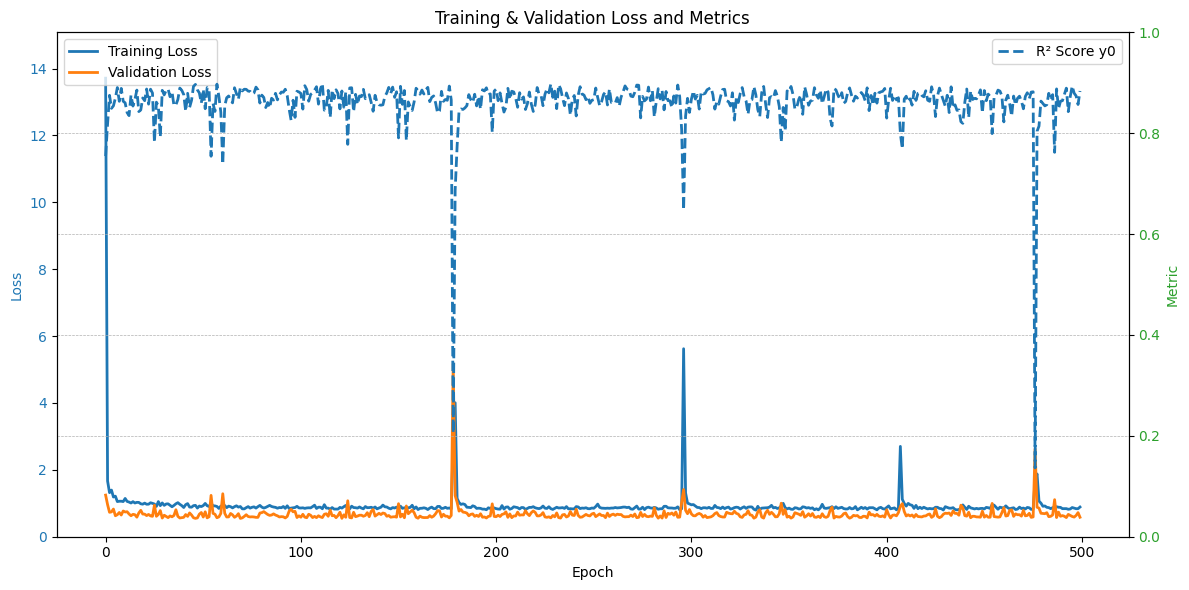

Training: filter_size=7, learning_rate=0.01, dropout=0.01
Saving best model to /home/klamdibih/Deep-Chemometrics/models/Darionet_Mango_uncertainty_best.pth
Epoch 1/500 | Train Loss: 16.4693 | Val Loss: 1.4539 | Val Mean Metrics: 0.7252
Model saved at epoch 0 to /home/klamdibih/Deep-Chemometrics/models/Darionet_Mango_uncertainty_best.pth
Model saved at epoch 0 to /home/klamdibih/Deep-Chemometrics/models/Darionet_Mango_uncertainty_best.pth
Epoch 2/500 | Train Loss: 1.6165 | Val Loss: 0.9591 | Val Mean Metrics: 0.8025
Model saved at epoch 1 to /home/klamdibih/Deep-Chemometrics/models/Darionet_Mango_uncertainty_best.pth
Epoch 3/500 | Train Loss: 1.3379 | Val Loss: 1.0444 | Val Mean Metrics: 0.7945
Epoch 4/500 | Train Loss: 1.2128 | Val Loss: 0.8798 | Val Mean Metrics: 0.8226
Model saved at epoch 3 to /home/klamdibih/Deep-Chemometrics/models/Darionet_Mango_uncertainty_best.pth
Epoch 5/500 | Train Loss: 1.1615 | Val Loss: 0.7683 | Val Mean Metrics: 0.8368
Model saved at epoch 4 to /home/klam

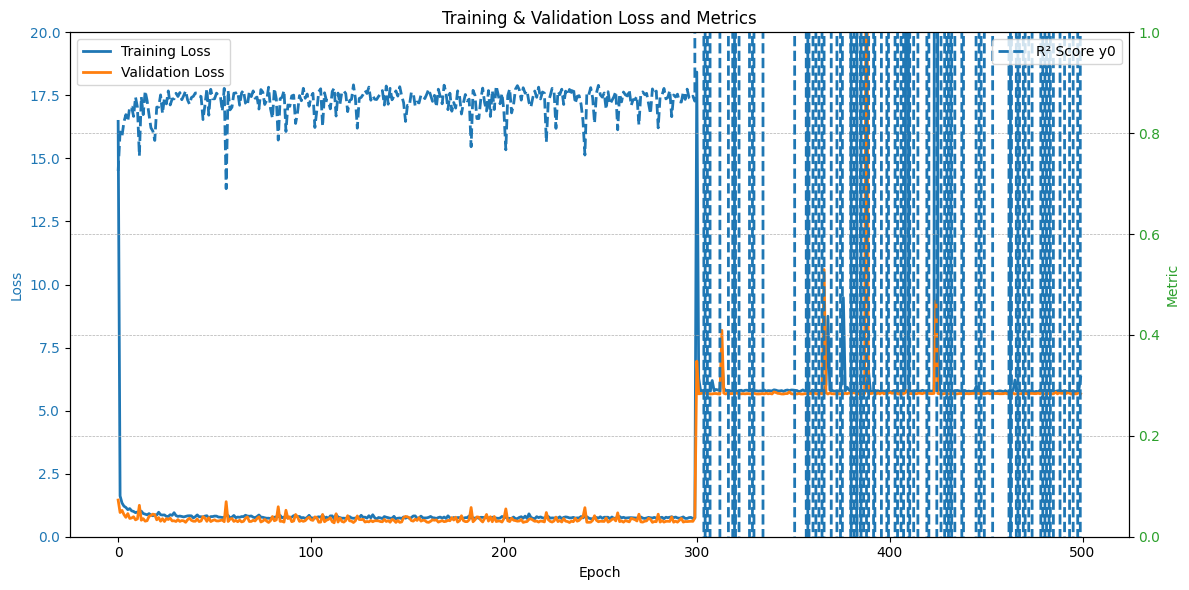

Training: filter_size=7, learning_rate=0.01, dropout=0.1
Saving best model to /home/klamdibih/Deep-Chemometrics/models/Darionet_Mango_uncertainty_best.pth
Epoch 1/500 | Train Loss: 22.4537 | Val Loss: 1.2650 | Val Mean Metrics: 0.7455
Model saved at epoch 0 to /home/klamdibih/Deep-Chemometrics/models/Darionet_Mango_uncertainty_best.pth
Model saved at epoch 0 to /home/klamdibih/Deep-Chemometrics/models/Darionet_Mango_uncertainty_best.pth
Epoch 2/500 | Train Loss: 4.5478 | Val Loss: 1.4122 | Val Mean Metrics: 0.7383
Epoch 3/500 | Train Loss: 3.5877 | Val Loss: 1.7130 | Val Mean Metrics: 0.5602
Epoch 4/500 | Train Loss: 3.3790 | Val Loss: 0.8763 | Val Mean Metrics: 0.8021
Model saved at epoch 3 to /home/klamdibih/Deep-Chemometrics/models/Darionet_Mango_uncertainty_best.pth
Epoch 5/500 | Train Loss: 3.0150 | Val Loss: 0.7399 | Val Mean Metrics: 0.8486
Model saved at epoch 4 to /home/klamdibih/Deep-Chemometrics/models/Darionet_Mango_uncertainty_best.pth
Epoch 6/500 | Train Loss: 2.8887 | Va

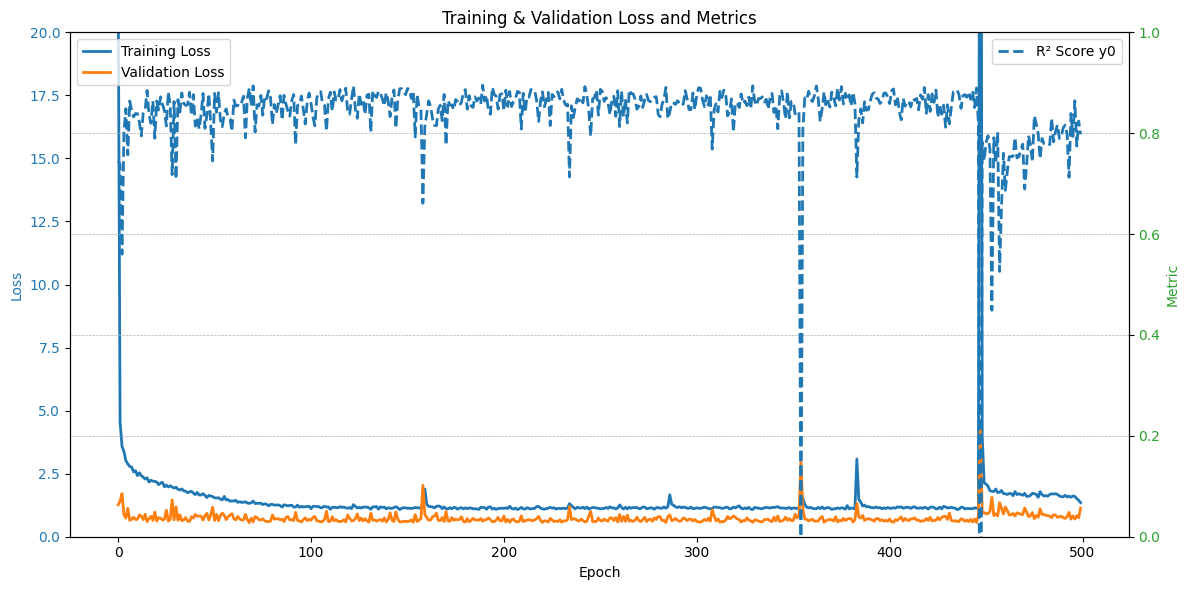

Training: filter_size=7, learning_rate=0.01, dropout=0.2
Saving best model to /home/klamdibih/Deep-Chemometrics/models/Darionet_Mango_uncertainty_best.pth
Epoch 1/500 | Train Loss: 18.7690 | Val Loss: 2.0160 | Val Mean Metrics: 0.5752
Model saved at epoch 0 to /home/klamdibih/Deep-Chemometrics/models/Darionet_Mango_uncertainty_best.pth
Model saved at epoch 0 to /home/klamdibih/Deep-Chemometrics/models/Darionet_Mango_uncertainty_best.pth
Epoch 2/500 | Train Loss: 6.4620 | Val Loss: 1.0831 | Val Mean Metrics: 0.7901
Model saved at epoch 1 to /home/klamdibih/Deep-Chemometrics/models/Darionet_Mango_uncertainty_best.pth
Epoch 3/500 | Train Loss: 5.7589 | Val Loss: 0.9434 | Val Mean Metrics: 0.7736
Epoch 4/500 | Train Loss: 5.4096 | Val Loss: 1.1520 | Val Mean Metrics: 0.7451
Epoch 5/500 | Train Loss: 4.9410 | Val Loss: 0.8387 | Val Mean Metrics: 0.7910
Model saved at epoch 4 to /home/klamdibih/Deep-Chemometrics/models/Darionet_Mango_uncertainty_best.pth
Epoch 6/500 | Train Loss: 4.9308 | Va

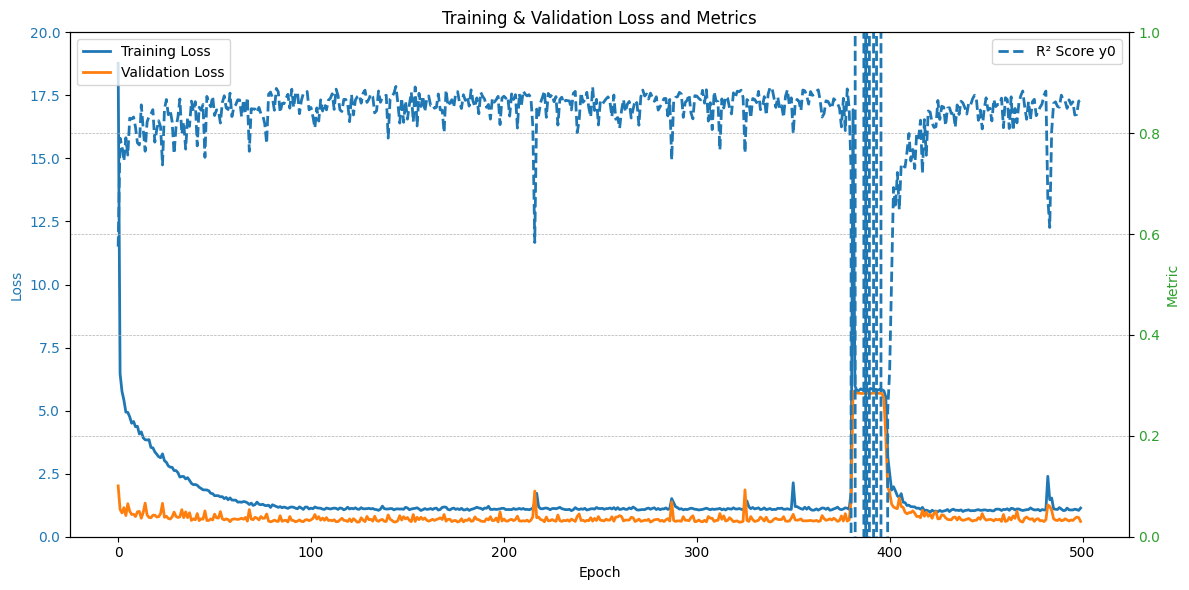

In [10]:
os.environ["CUDA_LAUNCH_BLOCKING"] = "1"

# Hyperparameters 
filter_sizes = [3, 5, 7]
learning_rates = [0.0001, 0.001, 0.01]
dropouts = [0.02, 0.01, 0.1, 0.2]
N = 100
# List to store all results
results = []

# Grid Search over all combinations
for f_size, lr, drop in product(filter_sizes, learning_rates, dropouts):
    print(f"Training: filter_size={f_size}, learning_rate={lr}, dropout={drop}")

    # Model initialization
    model = Darionet(mean=mean, std=std, filter_size=f_size, reg_beta=0.01,
                     input_dims=x_cal.shape[1], out_dims=1, p=drop).to(config.device)

    optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=0.015)
    criterion = torch.nn.MSELoss(reduction='mean')

    trainer = Trainer(model=model, optimizer=optimizer, criterion=criterion,
                      train_loader=cal_loader, val_loader=val_loader, config=config)

    # Training
    train_losses, val_losses, val_r2_scores, final_path = trainer.train()

    # Load the best model
    model.load_state_dict(torch.load(final_path, map_location=config.device))
    model.train()

    # MC Dropout predictions
    predictions = np.zeros((len(val_loader.dataset), N))
    targets = np.zeros((len(val_loader.dataset), 1))

    for k in range(N):
        idx = 0
        for input, target in val_loader:
            input = input.to(config.device).float()
            target = target.float()
            with torch.no_grad():
                output = model(input[:, None])
                predictions[idx:idx + input.size(0), k] = output.cpu().numpy().squeeze()
            targets[idx:idx + target.size(0)] = target.cpu().numpy().reshape(-1, 1)
            idx += input.size(0)

    # Metrics calculation
    mean_predictions = predictions.mean(axis=1)
    uncertainties = predictions.std(axis=1)
    rmse = np.sqrt(np.mean((mean_predictions - targets.squeeze()) ** 2))
    coverage = ((targets[:, 0] >= (mean_predictions - 3 * uncertainties)) &
                (targets[:, 0] <= (mean_predictions + 3 * uncertainties))).mean() * 100

    results.append({
        "filter_size": f_size,
        "learning_rate": lr,
        "dropout": drop,
        "rmse": rmse,
        "std": uncertainties.mean(),
        "coverage": coverage
    })
# Convert to DataFrame
df_results = pd.DataFrame(results)

# Save results
df_results.to_csv("result_csv/darionet_mc_dropout.csv", index=False)



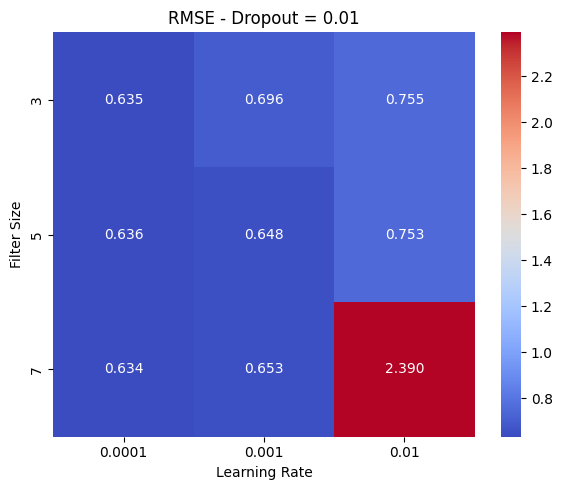

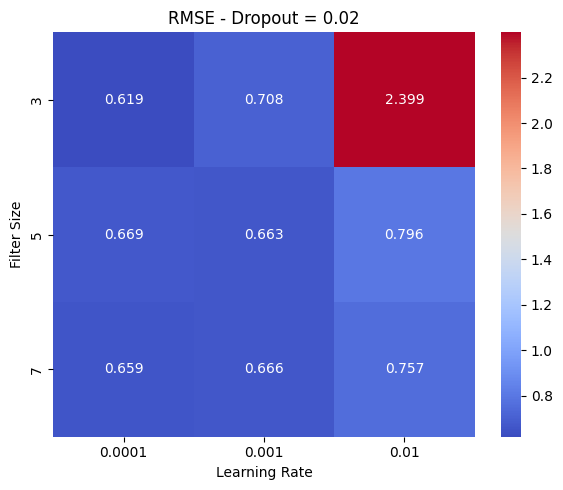

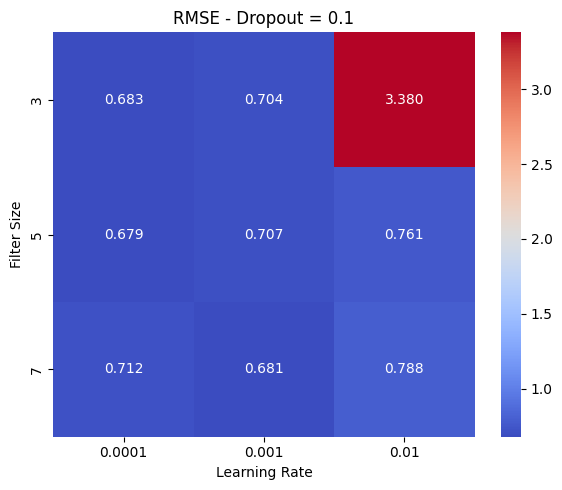

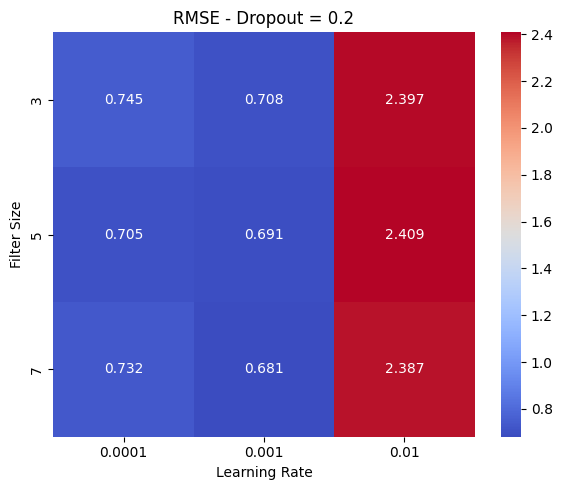

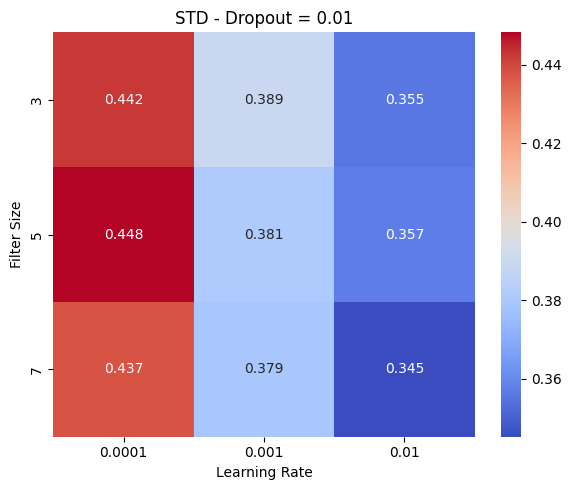

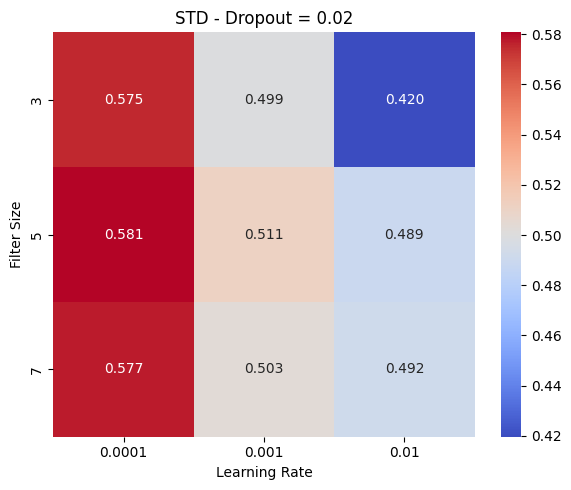

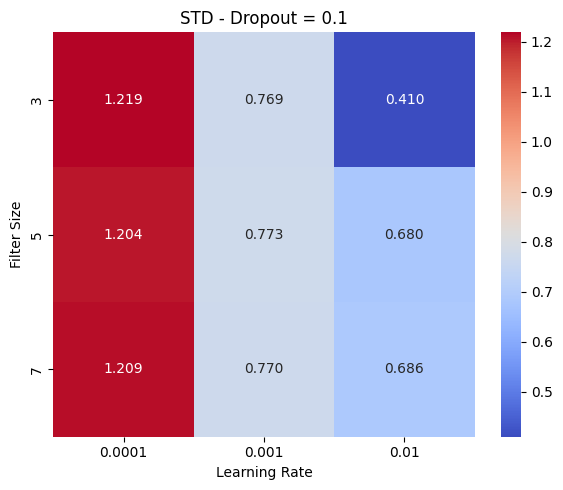

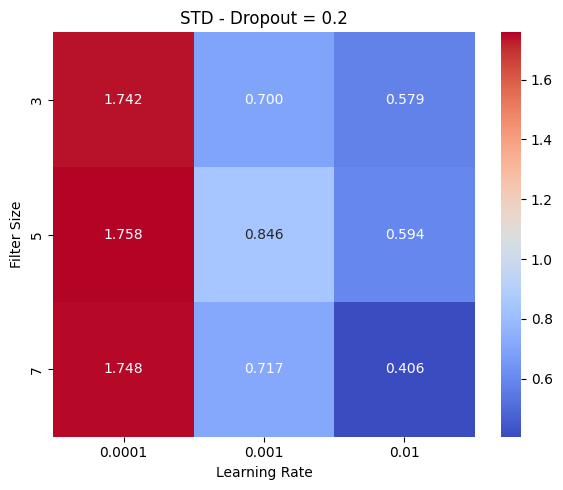

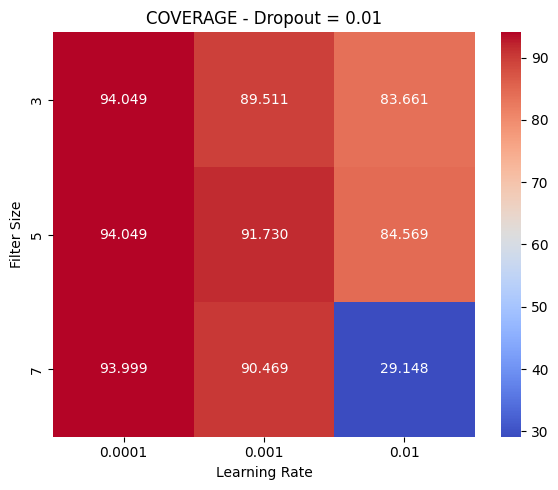

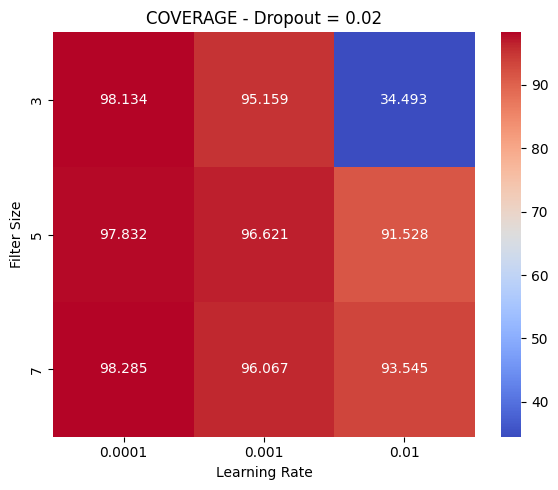

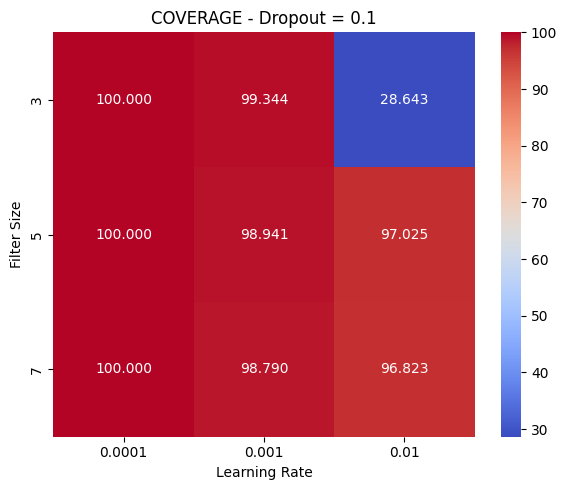

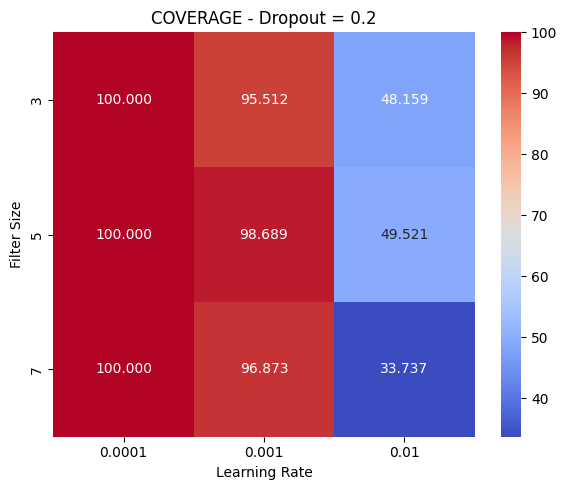

In [11]:
# Possible values
dropouts = sorted(df_results["dropout"].unique())
learning_rates = sorted(df_results["learning_rate"].unique())
filter_sizes = sorted(df_results["filter_size"].unique())


os.makedirs("figure/darionet_mc_dropout", exist_ok=True)

# Display and save heatmaps
for metric in ["rmse", "std", "coverage"]:
    for d in dropouts:
        pivot = df_results[df_results["dropout"] == d].pivot(
            index="filter_size", columns="learning_rate", values=metric
        )
        plt.figure(figsize=(6, 5), facecolor="white")
        sns.heatmap(pivot, annot=True, fmt=".3f", cmap="coolwarm")
        plt.title(f"{metric.upper()} - Dropout = {d}")
        plt.xlabel("Learning Rate")
        plt.ylabel("Filter Size")
        plt.tight_layout()
        
       
        dropout_str = str(d).replace(".", "_")
        plt.savefig(f"figure/darionet_mc_dropout/{metric}_dropout_{dropout_str}.pdf", dpi=500)
        plt.show()


Final training with filter_size=3, learning_rate=0.0001
Saving best model to /home/klamdibih/Deep-Chemometrics/models/Darionet_Mango_uncertainty_best.pth
Epoch 1/500 | Train Loss: 106.0534 | Val Loss: 21.4492 | Val Mean Metrics: -0.7701
Model saved at epoch 0 to /home/klamdibih/Deep-Chemometrics/models/Darionet_Mango_uncertainty_best.pth
Epoch 2/500 | Train Loss: 12.1156 | Val Loss: 6.1633 | Val Mean Metrics: -0.0079
Model saved at epoch 1 to /home/klamdibih/Deep-Chemometrics/models/Darionet_Mango_uncertainty_best.pth
Epoch 3/500 | Train Loss: 5.6894 | Val Loss: 3.4349 | Val Mean Metrics: 0.4145
Model saved at epoch 2 to /home/klamdibih/Deep-Chemometrics/models/Darionet_Mango_uncertainty_best.pth
Model saved at epoch 2 to /home/klamdibih/Deep-Chemometrics/models/Darionet_Mango_uncertainty_best.pth
Epoch 4/500 | Train Loss: 3.9428 | Val Loss: 2.4167 | Val Mean Metrics: 0.5692
Model saved at epoch 3 to /home/klamdibih/Deep-Chemometrics/models/Darionet_Mango_uncertainty_best.pth
Epoch 5/5

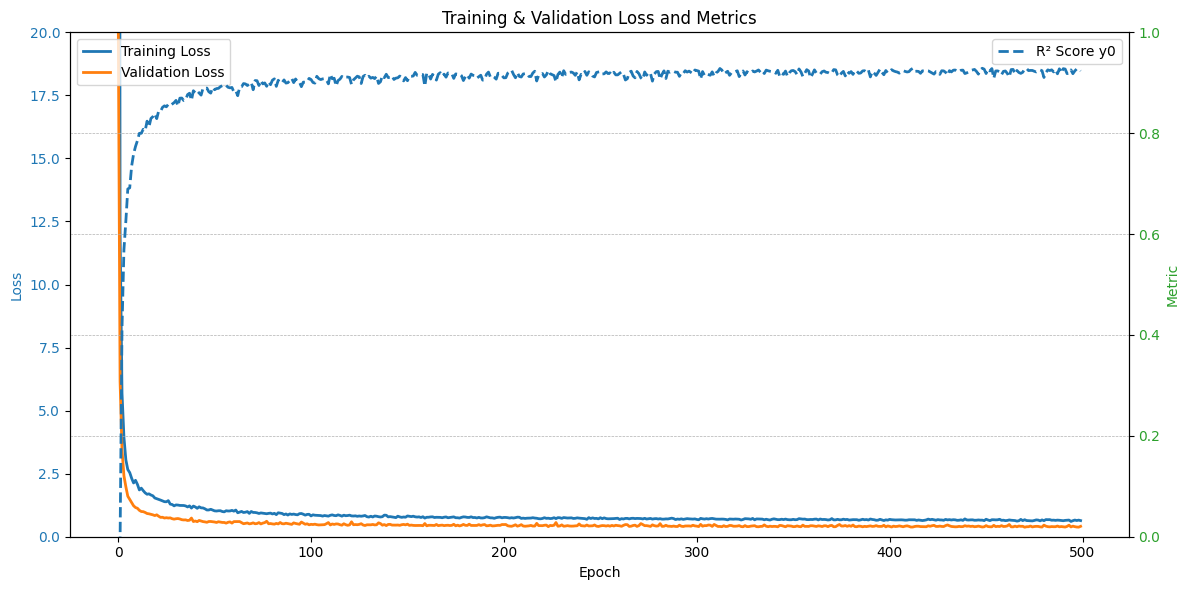

/tmp/ipykernel_6186/1941035411.py:23: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(final_path, map_location=config.device))



Final Darionet model results WITH MC Dropout ON TEST SET:
   - RMSE       : 0.9965
   - R²         : 0.8606
   - Mean uncertainty (std) : 0.6110
   - Coverage   : 91.92%


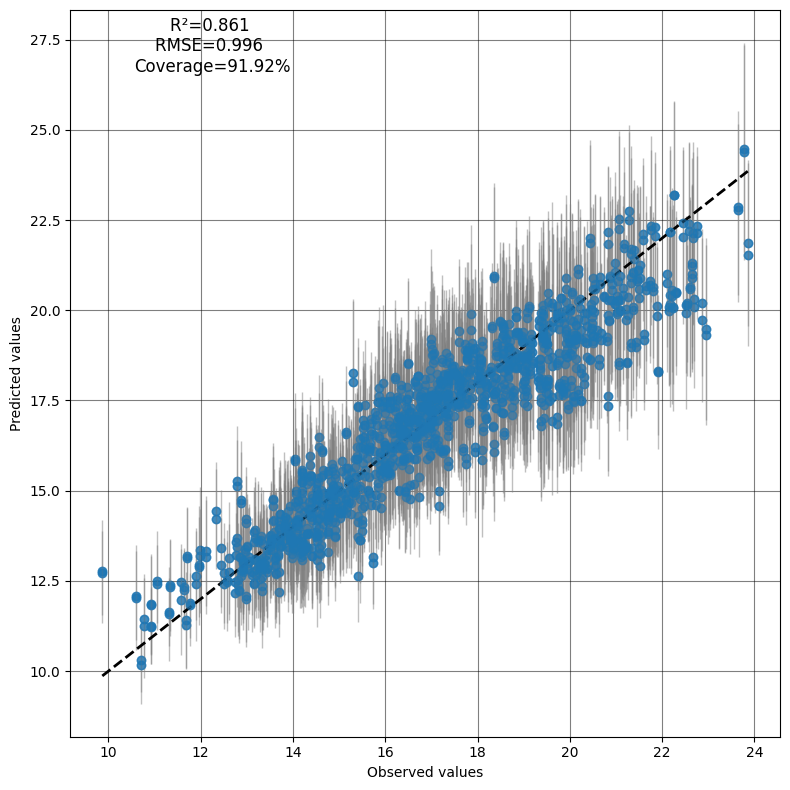

In [7]:
# Best hyperparameters
best_filter_size = 3
best_learning_rate = 0.0001
N = 100  # number of MC Dropout passes

print(f"Final training with filter_size={best_filter_size}, learning_rate={best_learning_rate}")

# Model initialization
model = Darionet(mean=mean, std=std, filter_size=best_filter_size, reg_beta=0.01,
                 input_dims=x_cal.shape[1], out_dims=1, p=0.02)
model.to(config.device)

optimizer = torch.optim.Adam(model.parameters(), lr=best_learning_rate, weight_decay=0.015)
criterion = torch.nn.MSELoss(reduction='mean')

trainer = Trainer(model=model, optimizer=optimizer, criterion=criterion,
                  train_loader=cal_loader, val_loader=val_loader, config=config)

# Training
train_losses, val_losses, val_r2_scores, final_path = trainer.train()

# Load best model
model.load_state_dict(torch.load(final_path, map_location=config.device))
model.train()

# MC Dropout predictions on TEST SET
predictions = np.zeros((len(test_loader.dataset), N))
targets = np.zeros((len(test_loader.dataset), 1))

for k in range(N):
    idx = 0
    for input, target in test_loader:
        input = input.to(config.device).float()
        target = target.float()
        with torch.no_grad():
            output = model(input[:, None])
            predictions[idx:idx + input.size(0), k] = output.cpu().numpy().squeeze()
        targets[idx:idx + target.size(0)] = target.cpu().numpy().reshape(-1, 1)
        idx += input.size(0)

# Metrics computation
mean_predictions = predictions.mean(axis=1)
uncertainties = predictions.std(axis=1)
rmse = np.sqrt(np.mean((mean_predictions - targets.squeeze()) ** 2))
r2 = r2_score(targets.squeeze(), mean_predictions)
lower_bound = mean_predictions - 3 * uncertainties
upper_bound = mean_predictions + 3 * uncertainties
coverage = ((targets[:, 0] >= lower_bound) & (targets[:, 0] <= upper_bound)).mean() * 100

# Results
print(f"\nFinal Darionet model results WITH MC Dropout ON TEST SET:")
print(f"   - RMSE       : {rmse:.4f}")
print(f"   - R²         : {r2:.4f}")
print(f"   - Mean uncertainty (std) : {uncertainties.mean():.4f}")
print(f"   - Coverage   : {coverage:.2f}%")

# Final visualization
fig, ax = plt.subplots(figsize=(8, 8))

ax.scatter(targets, mean_predictions, alpha=0.7)
ax.text(0.2, 0.95, f"R²={r2:.3f} \nRMSE={rmse:.3f} \nCoverage={coverage:.2f}%",
        ha='center', va='center', fontsize=12, transform=ax.transAxes)

ax.errorbar(
    targets.squeeze(),
    mean_predictions,
    yerr=3 * uncertainties,
    fmt='o',
    ecolor='gray',
    elinewidth=1,
    alpha=0.5,
    label="Uncertainty (±3σ)"
)

ax.plot(
    [targets.min(), targets.max()],
    [targets.min(), targets.max()],
    'k--', lw=2,
    label="Perfect prediction"
)

ax.set_xlabel("Observed values")
ax.set_ylabel("Predicted values")
ax.grid(color='black', alpha=0.5)
ax.set_facecolor('white')
fig.patch.set_facecolor('white')

plt.tight_layout()
plt.savefig("figure/darionet_mc_dropout/best_model.pdf", dpi=500, facecolor='white')
plt.show()


# SWAG

In [14]:
num_epochs = 100

# Hyperparameter grids
lr_swag_values = [0.0001, 0.0005, 0.001]
filter_sizes = [3, 5, 7]
sample_values = [1, 2, 5, 10]

results = []

for f_size, lr_swag in product(filter_sizes, lr_swag_values):
    print(f"Training SWAG-Darionet: filter_size={f_size}, learning_rate={lr_swag}")

    # Initialize base model
    base_model = Darionet(mean=mean, std=std, filter_size=f_size, reg_beta=0.01,
                          input_dims=x_cal.shape[1], out_dims=1, p=0.0).to("cuda")

    config.update_config(learning_rate=lr_swag)
    optimizer = torch.optim.SGD(base_model.parameters(), lr=config.learning_rate)
    criterion = nn.MSELoss(reduction='mean')

    trainer = Trainer(model=base_model, optimizer=optimizer, criterion=criterion,
                      train_loader=cal_loader, val_loader=val_loader, config=config)

    # SWAG model
    swag_model = SWAG(base=base_model, no_cov_mat=False).to("cuda")

    # Training and model collection
    for epoch in range(num_epochs):
        trainer.train_one_epoch()
        swag_model.collect_model(base_model)

    # Loop over SWAG samples
    for j, sample_param in enumerate(sample_values):
        predictions = np.zeros((len(val_loader.dataset), N))
        targets = np.zeros((len(val_loader.dataset), 1))

        for h in range(N):
            swag_model.sample(scale=sample_param)
            swag_model.base.eval()

            idx = 0
            for input, target in val_loader:
                input = input.cuda(non_blocking=True).float()
                target = target.float()
                with torch.no_grad():
                    output = swag_model(input[:, None])
                    predictions[idx: idx + input.size(0), h] = output.cpu().numpy().squeeze()
                targets[idx: idx + target.size(0)] = target.cpu().numpy().reshape(-1, 1)
                idx += input.size(0)

        # Compute metrics
        mean_predictions = predictions.mean(axis=1)
        uncertainties = predictions.std(axis=1)
        rmse = np.sqrt(np.mean((mean_predictions - targets.squeeze()) ** 2))
        coverage = ((targets[:, 0] >= mean_predictions - 3 * uncertainties) &
                    (targets[:, 0] <= mean_predictions + 3 * uncertainties)).mean() * 100

        results.append({
            "filter_size": f_size,
            "learning_rate": lr_swag,
            "sample": sample_param,
            "rmse": rmse,
            "std": uncertainties.mean(),
            "coverage": coverage
        })

# Convert results to DataFrame
df_swag = pd.DataFrame(results)
df_swag.to_csv("result_csv/swag_darionet_results.csv", index=False)


Training SWAG-Darionet: filter_size=3, learning_rate=0.0001
Training SWAG-Darionet: filter_size=3, learning_rate=0.0005
Training SWAG-Darionet: filter_size=3, learning_rate=0.001
Training SWAG-Darionet: filter_size=5, learning_rate=0.0001
Training SWAG-Darionet: filter_size=5, learning_rate=0.0005
Training SWAG-Darionet: filter_size=5, learning_rate=0.001
Training SWAG-Darionet: filter_size=7, learning_rate=0.0001
Training SWAG-Darionet: filter_size=7, learning_rate=0.0005
Training SWAG-Darionet: filter_size=7, learning_rate=0.001


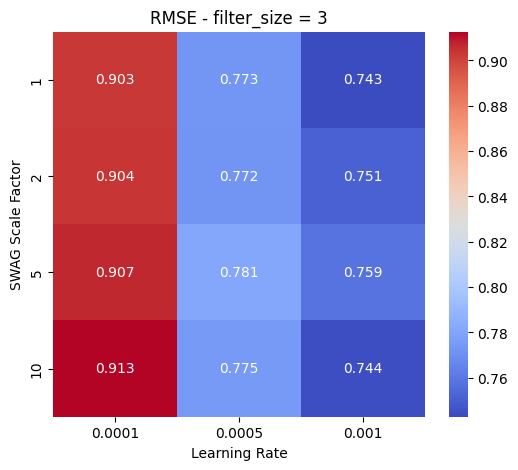

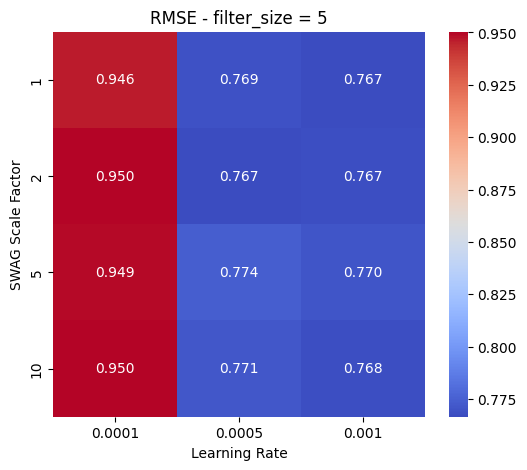

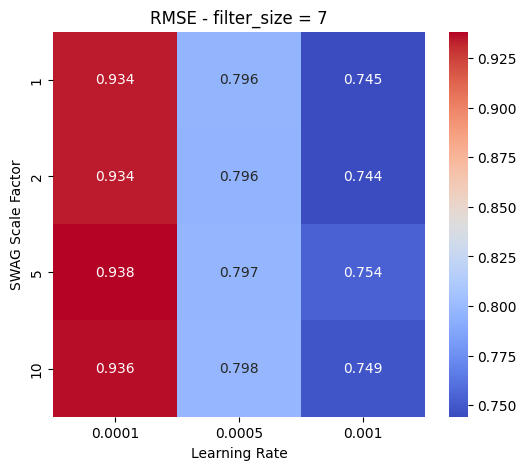

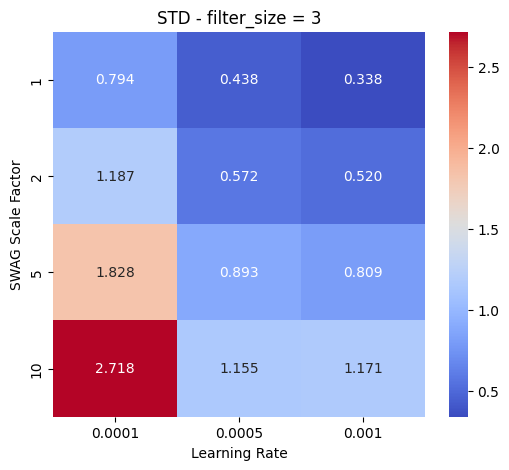

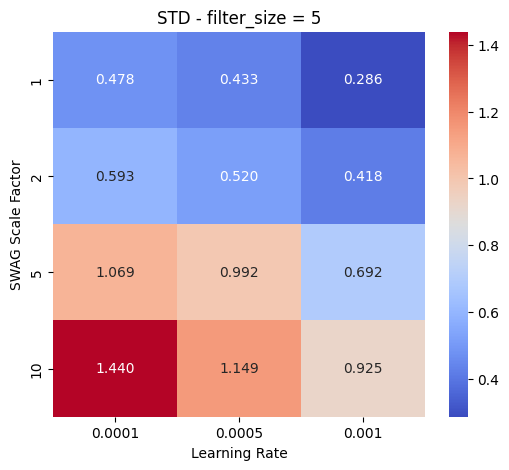

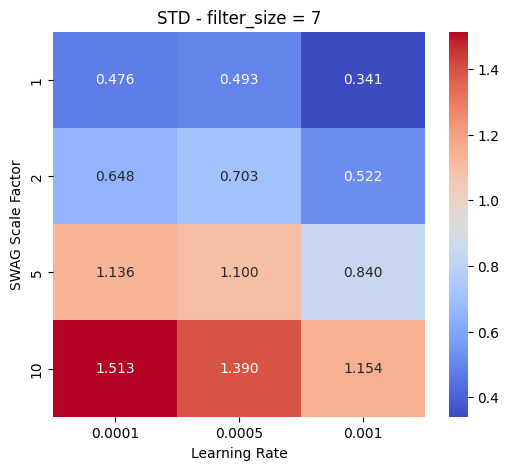

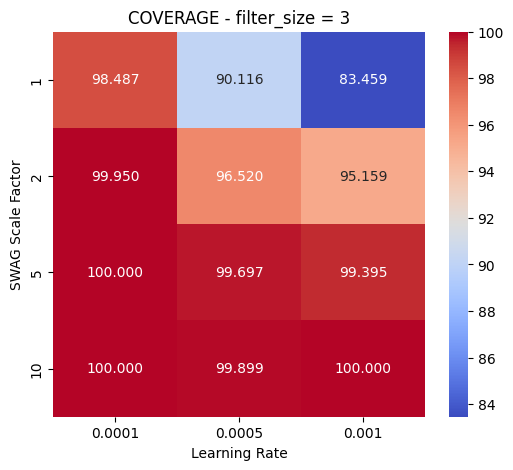

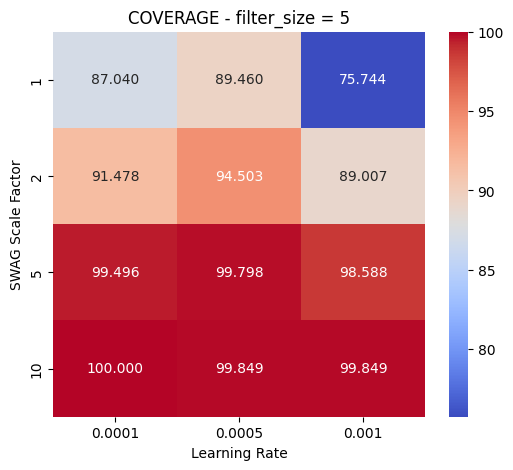

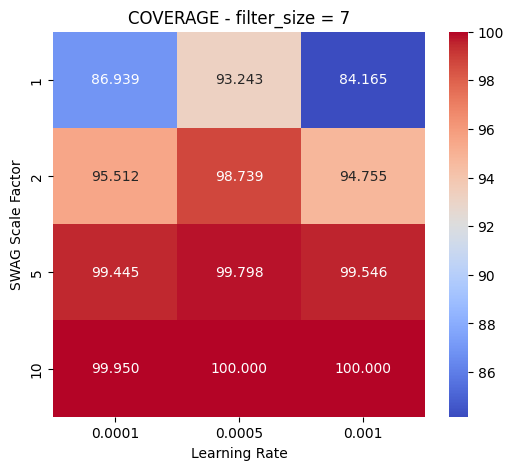

In [15]:
for metric in ["rmse", "std", "coverage"]:
    for f_size in filter_sizes:
        pivot = df_swag[df_swag["filter_size"] == f_size].pivot(index="sample", columns="learning_rate", values=metric)
        plt.figure(figsize=(6, 5), facecolor="white")
        sns.heatmap(pivot, annot=True, fmt=".3f", cmap="coolwarm")
        plt.title(f"{metric.upper()} - filter_size = {f_size}")
        plt.xlabel("Learning Rate")
        plt.ylabel("SWAG Scale Factor")
        os.makedirs("figure/SWAG_darionet", exist_ok=True)
        plt.savefig(f"figure/SWAG_darionet/{metric}_filter{f_size}.pdf", dpi=500)
        plt.show()

Training Darionet with SWAG — filter_size=7, lr=0.001

SWAG Results:
  - RMSE: 1.0059
  - R²:   0.8579
  - STD:  0.6783
  - Coverage: 94.61%


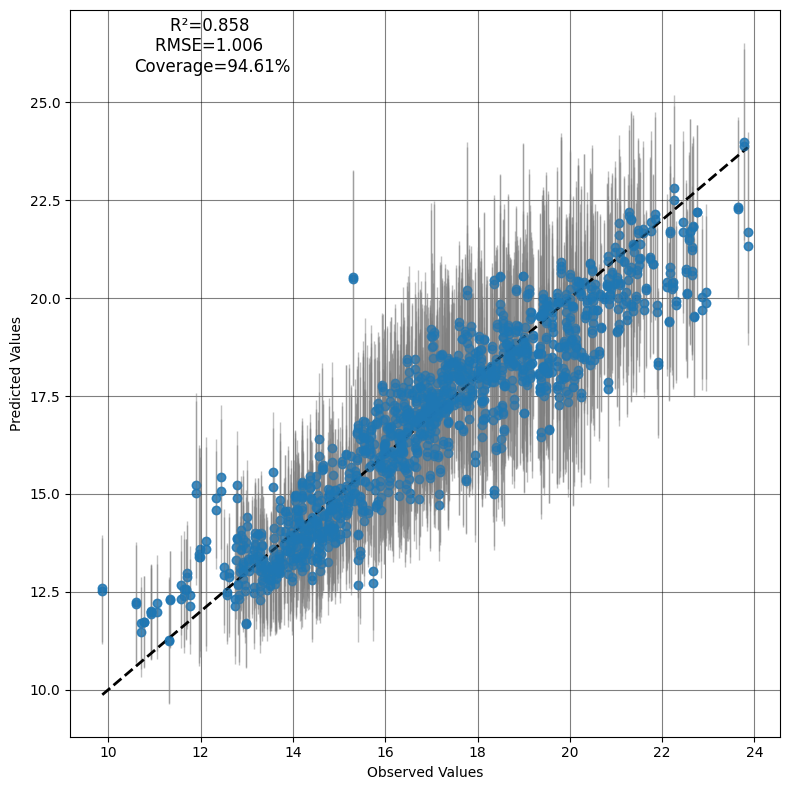

In [16]:
# Best configuration from previous grid search
lr_swag_values = [0.001]  
sample_values = [2.0]
num_epochs = 100
N = 100
filter_size = 7
dropout = 0.00 

# Initialize metrics
mean_rmse = np.zeros((len(lr_swag_values), len(sample_values)))
mean_std = np.zeros((len(lr_swag_values), len(sample_values)))
mean_coverage = np.zeros((len(lr_swag_values), len(sample_values)))

for i, lr_swag in enumerate(lr_swag_values):
    print(f"Training Darionet with SWAG — filter_size={filter_size}, lr={lr_swag}")

    # Initialize base model with correct filter_size 
    model = Darionet(mean=mean, std=std, filter_size=filter_size, reg_beta=0.01,
                     input_dims=x_cal.shape[1], out_dims=1, p=dropout).to("cuda")

    optimizer = torch.optim.SGD(model.parameters(), lr=lr_swag)
    criterion = nn.MSELoss(reduction='mean')

    trainer = Trainer(model=model, optimizer=optimizer, criterion=criterion,
                      train_loader=cal_loader, val_loader=val_loader, config=config)

 
    swag_model = SWAG(base=model, no_cov_mat=False).to("cuda")

    # Training + SWAG model collection
    for epoch in range(num_epochs):
        trainer.train_one_epoch()
        swag_model.collect_model(model)

    # Sample and evaluate
    for j, sample_param in enumerate(sample_values):
        predictions = np.zeros((len(test_loader.dataset), N))
        targets = np.zeros((len(test_loader.dataset), 1))

        for h in range(N):
            swag_model.sample(sample_param)
            swag_model.base.eval()

            idx = 0
            for input, target in test_loader:
                input = input.cuda(non_blocking=True).float()
                target = target.float()
                with torch.no_grad():
                    output = swag_model(input[:, None])
                    predictions[idx:idx + input.size(0), h] = output.cpu().numpy().squeeze()
                targets[idx:idx + target.size(0)] = target.cpu().numpy().reshape(-1, 1)
                idx += input.size(0)

        # Compute metrics
        mean_predictions = predictions.mean(axis=1)
        uncertainties = predictions.std(axis=1)
        rmse = np.sqrt(np.mean((mean_predictions - targets.squeeze()) ** 2))
        r2 = r2_score(targets.squeeze(), mean_predictions)
        lower_bound = mean_predictions - 3 * uncertainties
        upper_bound = mean_predictions + 3 * uncertainties
        coverage = ((targets[:, 0] >= lower_bound) & (targets[:, 0] <= upper_bound)).mean()

        
        print(f"\nSWAG Results:")
        print(f"  - RMSE: {rmse:.4f}")
        print(f"  - R²:   {r2:.4f}")
        print(f"  - STD:  {uncertainties.mean():.4f}")
        print(f"  - Coverage: {coverage * 100:.2f}%")

        # Plot
        fig, ax = plt.subplots(figsize=(8, 8))
        ax.scatter(targets, mean_predictions, alpha=0.7)
        ax.text(0.2, 0.95, f"R²={r2:.3f} \nRMSE={rmse:.3f} \nCoverage={coverage * 100:.2f}%",
                ha='center', va='center', fontsize=12, transform=ax.transAxes)
        ax.errorbar(targets.squeeze(), mean_predictions, yerr=uncertainties * 3,
                    fmt='o', ecolor='gray', elinewidth=1, alpha=0.5, label="Uncertainty")
        ax.plot([targets.min(), targets.max()], [targets.min(), targets.max()],
                'k--', lw=2, label="Perfect Prediction")
        ax.set_xlabel("Observed Values")
        ax.set_ylabel("Predicted Values")
        ax.grid(color='black', alpha=0.5)
        ax.set_facecolor('white')
        fig.patch.set_facecolor('white')
        plt.tight_layout()
        plt.savefig(f"figure/SWAG_darionet/best_model.pdf", dpi=500, facecolor='white')
        plt.show()


# Stacking

In [20]:
# Hyperparameters
filter_sizes = [3, 5, 7]
LR_list = [0.0001, 0.001, 0.01]
N_models_list = [10, 30, 50, 100]
p = 0.02  

results = []

# Training phase: train and save base models
for f_size, lr in product(filter_sizes, LR_list):
    model = Darionet(mean=mean, std=std, filter_size=f_size, reg_beta=0.01,
                     input_dims=x_cal.shape[1], out_dims=1, p=p).to(device)

    optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=0.015)
    criterion = nn.MSELoss()
    trainer = Trainer(model, optimizer, criterion, cal_loader, val_loader, config)

    for epoch in range(100):
        trainer.train_one_epoch()

    model_name = f"darionet_base_f{f_size}_p{p}_lr{lr}.pt"
    os.makedirs("ensemble_models", exist_ok=True)
    torch.save(model.state_dict(), f"ensemble_models/{model_name}")

In [31]:
results = []

for i, N_models in enumerate(N_models_list):
    for j, f_size in enumerate(filter_sizes):
        for k, lr in enumerate(LR_list):
            set_seed(42)

        
            model = Darionet(mean=mean, std=std, filter_size=f_size, reg_beta=0.01,
                             input_dims=x_cal.shape[1], out_dims=1, p=p).to(device)

            path = f'ensemble_models/darionet_base_f{f_size}_p{p}_lr{lr}.pt'
            model.load_state_dict(torch.load(path, map_location=device))

            optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=0.015)
            criterion = nn.MSELoss()
            trainer = Trainer(model, optimizer, criterion, cal_loader, val_loader, config)

            # Generate deep ensemble of models
            ensemble_models = []
            for epoch in range(N_models):
                trainer.train_one_epoch()
                ensemble_models.append(copy.deepcopy(model.to("cpu")))

            # Evaluation on validation set
            predictions = np.zeros((len(val_loader.dataset), N_models))
            targets = np.zeros((len(val_loader.dataset), 1))

            with torch.no_grad():
                for m, mdl in enumerate(ensemble_models):
                    mdl.eval().to(device)
                    idx = 0
                    for inputs, target in val_loader:
                        inputs = inputs.to(device)
                        target = target.float()
                        output = mdl(inputs[:, None])
                        predictions[idx:idx+inputs.size(0), m] = output.cpu().numpy().squeeze()
                        targets[idx:idx+target.size(0)] = target.cpu().numpy().reshape(-1, 1)
                        idx += inputs.size(0)

            # Compute metrics
            mean_preds = predictions.mean(axis=1)
            uncertainties = predictions.std(axis=1)

            rmse = np.sqrt(np.mean((mean_preds - targets.squeeze()) ** 2))
            lower = mean_preds - 3 * uncertainties
            upper = mean_preds + 3 * uncertainties
            covered = (targets[:, 0] >= lower) & (targets[:, 0] <= upper)
            coverage = 100 * covered.mean()

            # Save results
            results.append({
                "filter_size": f_size,
                "n_models": N_models,
                "lr": lr,
                "rmse": rmse,
                "std": uncertainties.mean(),
                "coverage": coverage
            })



df_results = pd.DataFrame(results)
df_results.to_csv("result_csv/stacking_darionet.csv", index=False)

/tmp/ipykernel_4089/238025513.py:13: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(path, map_location=device))


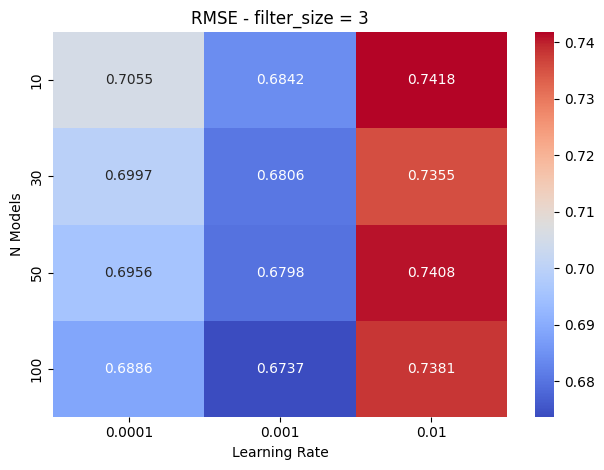

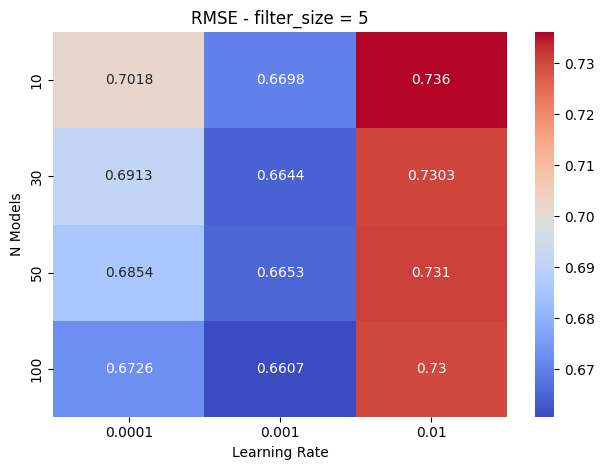

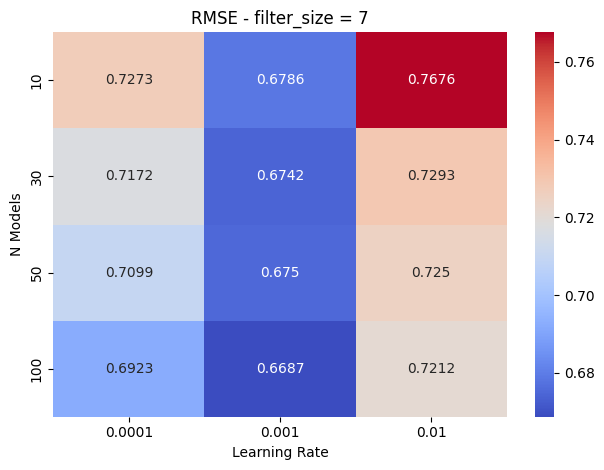

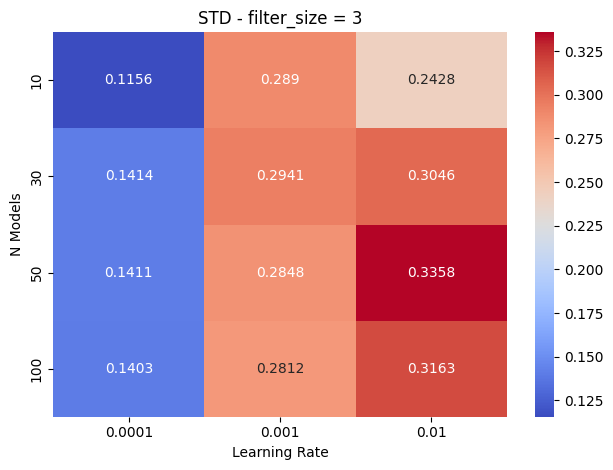

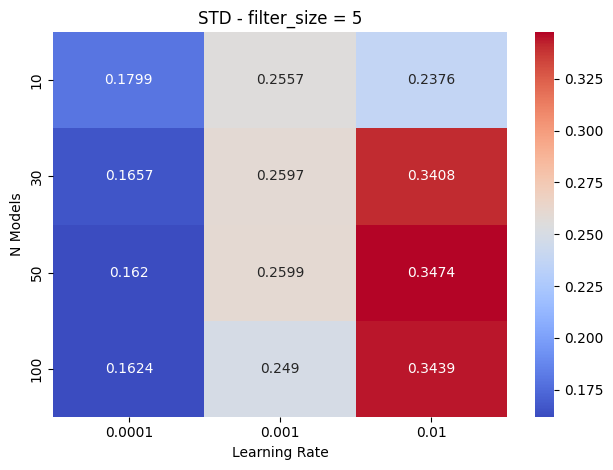

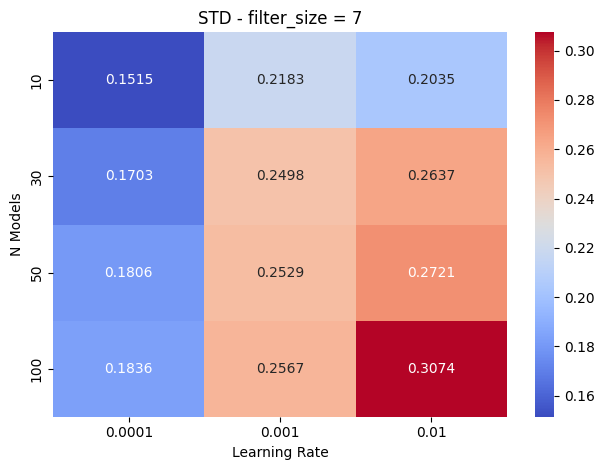

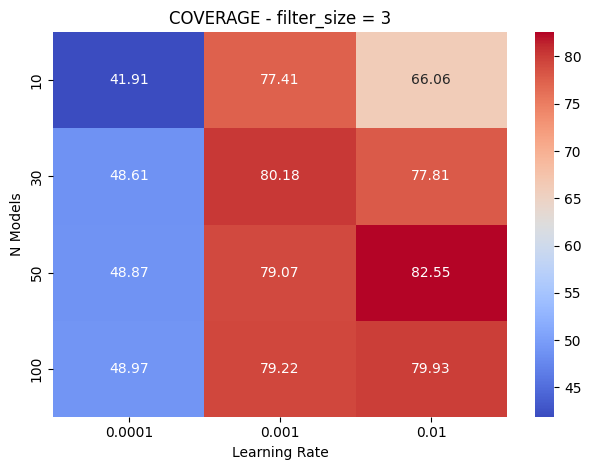

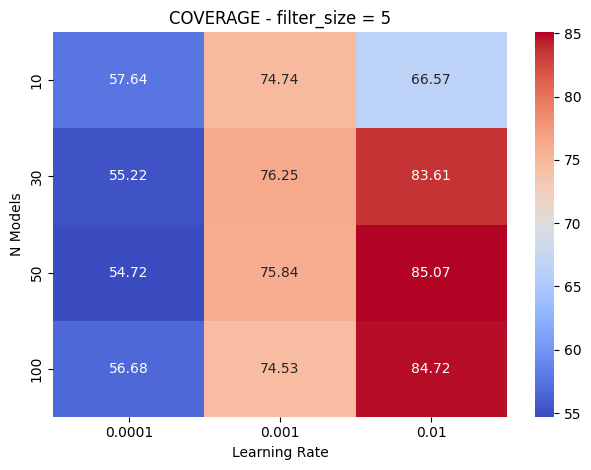

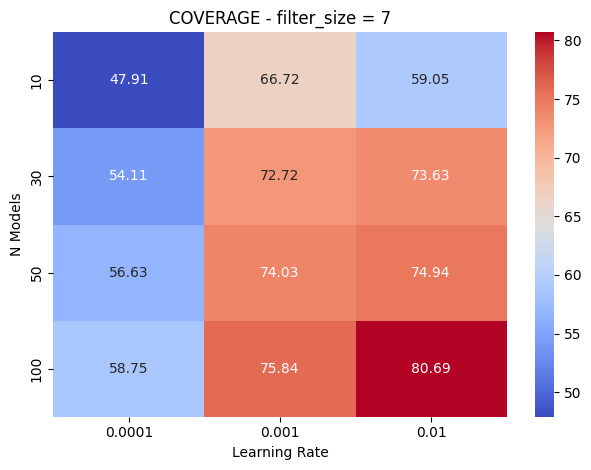

In [30]:

df = pd.read_csv("result_csv/stacking_darionet_with_filter.csv")



metrics = ["rmse", "std", "coverage"]

# Plot heatmaps for each filter size and metric
for metric in metrics:
    for f_size in sorted(df["filter_size"].unique()):
        df_sub = df[df["filter_size"] == f_size]

        heatmap_data = df_sub.pivot(index="n_models", columns="lr", values=metric)

        plt.figure(facecolor="white")
        sns.heatmap(heatmap_data, annot=True, cmap="coolwarm", fmt=".4g")
        plt.title(f"{metric.upper()} - filter_size = {f_size}")
        plt.xlabel("Learning Rate")
        plt.ylabel("N Models")
        plt.tight_layout()

        # Save the plot
        filename = f"figure/stacking/heatmap_{metric}_f{f_size}.pdf"
        plt.savefig(filename, dpi=500, facecolor='white')
        plt.show()


/tmp/ipykernel_4089/949880633.py:14: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(model_path, map_location=device))



Evaluation on Test Set
RMSE (Test): 0.9431
Mean STD (Test): 0.3477
Coverage (Test): 75.07%
R² (Test): 0.8751


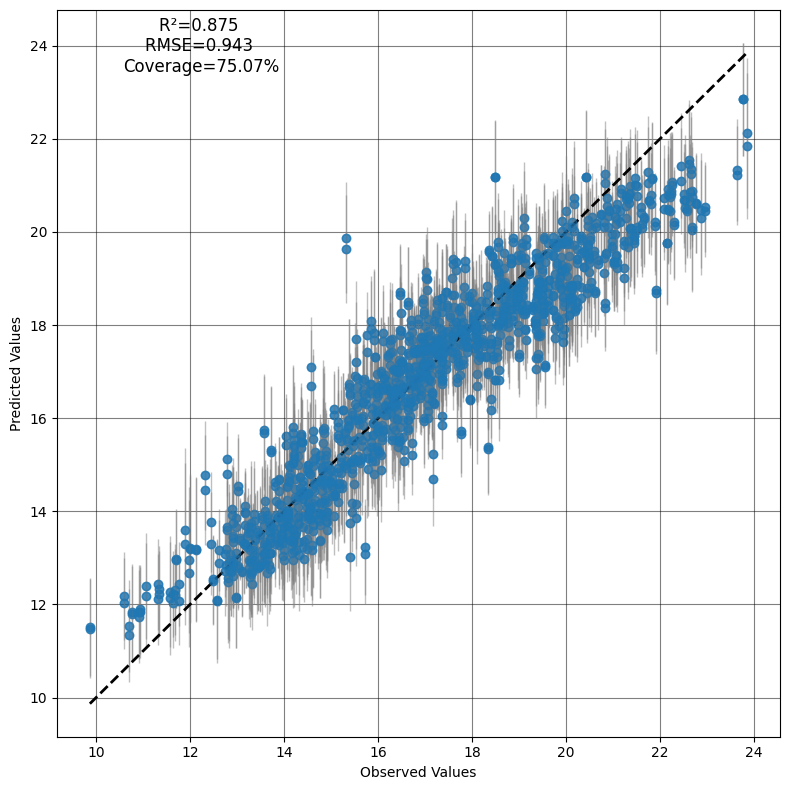

In [29]:
# Optimal configuration
filter_size = 5
n_models = 50
lr = 0.01
p = 0.02

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Load the base model
model = Darionet(mean=mean, std=std, filter_size=filter_size, reg_beta=0.01,
                 input_dims=x_cal.shape[1], out_dims=1, p=p).to(device)

model_path = f'ensemble_models/darionet_base_f{filter_size}_p{p}_lr{lr}.pt'
model.load_state_dict(torch.load(model_path, map_location=device))

# Optimizer and loss for fine-tuning
optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=0.015)
criterion = nn.MSELoss()
trainer = Trainer(model, optimizer, criterion, cal_loader, val_loader, config)

# Generate ensemble of models
ensemble_models = []
for _ in range(n_models):
    trainer.train_one_epoch()
    ensemble_models.append(copy.deepcopy(model.to("cpu")))

# Inference on test set
predictions = np.zeros((len(test_loader.dataset), n_models))
targets = np.zeros((len(test_loader.dataset), 1))

with torch.no_grad():
    for m, mdl in enumerate(ensemble_models):
        mdl.eval().to(device)
        idx = 0
        for inputs, target in test_loader:
            inputs = inputs.to(device)
            target = target.float()
            output = mdl(inputs[:, None])
            predictions[idx:idx+inputs.size(0), m] = output.cpu().numpy().squeeze()
            targets[idx:idx+target.size(0)] = target.cpu().numpy().reshape(-1, 1)
            idx += inputs.size(0)

# Compute uncertainty metrics
mean_preds = predictions.mean(axis=1)
uncertainties = predictions.std(axis=1)
rmse_test = np.sqrt(np.mean((mean_preds - targets.squeeze()) ** 2))
lower = mean_preds - 3 * uncertainties
upper = mean_preds + 3 * uncertainties
covered = (targets[:, 0] >= lower) & (targets[:, 0] <= upper)
coverage_test = 100 * covered.mean()
r2 = r2_score(targets.squeeze(), mean_preds)

# Print metrics
print("\nEvaluation on Test Set")
print(f"RMSE (Test): {rmse_test:.4f}")
print(f"Mean STD (Test): {uncertainties.mean():.4f}")
print(f"Coverage (Test): {coverage_test:.2f}%")
print(f"R² (Test): {r2:.4f}")

# Plot predictions vs. observed values
fig, ax = plt.subplots(figsize=(8, 8))
ax.scatter(targets, mean_preds, alpha=0.7)
ax.text(0.2, 0.95, f"R²={r2:.3f} \nRMSE={rmse_test:.3f} \nCoverage={coverage_test:.2f}%",
        ha='center', va='center', fontsize=12, transform=ax.transAxes)
ax.errorbar(targets.squeeze(), mean_preds, yerr=uncertainties * 3,
            fmt='o', ecolor='gray', elinewidth=1, alpha=0.5, label="Uncertainty")
ax.plot([targets.min(), targets.max()], [targets.min(), targets.max()],
        'k--', lw=2, label="Perfect Prediction")
ax.set_xlabel("Observed Values")
ax.set_ylabel("Predicted Values")
ax.grid(color='black', alpha=0.5)
ax.set_facecolor('white')
fig.patch.set_facecolor('white')
plt.tight_layout()

# Save the figure
os.makedirs("figure/stacking_darionet", exist_ok=True)
plt.savefig("figure/stacking_darionet/best_model.pdf", dpi=500, facecolor='white')
plt.show()
